In [1]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam

import tensorflow_datasets as tfds

import numpy as np
import matplotlib.pyplot as plt

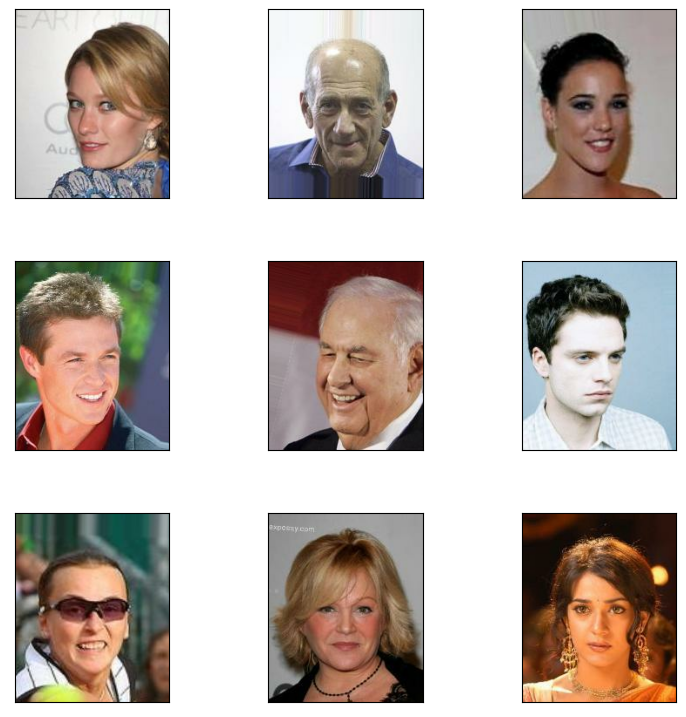

In [2]:
ds_train, ds_info = tfds.load('celeb_a', split='train', shuffle_files=True, with_info=True)
fig = tfds.show_examples(ds_train, ds_info)

In [3]:
batch_size = 128*4
image_shape = (64, 64, 3)


# def preprocess(features):
#     image = tf.image.resize(features['image'], image_shape[:2])
#     image = tf.cast(image, tf.float32)
#     image = (image-127.5)/127.5
#     return image

def preprocess(features):
    image = tf.image.resize(features['image'][:20000], image_shape[:2])
    image = tf.cast(image, tf.float32)
    image = (image-127.5)/127.5
    return image

# ds_train = ds_train.map(preprocess).shuffle(ds_info.splits['train'].num_examples).batch(batch_size, drop_remainder=True).repeat()
ds_train = ds_train.map(preprocess).shuffle(20000).batch(batch_size, drop_remainder=True).repeat()

# train_num = ds_info.splits['train'].num_examples
train_num = 20000
train_steps_per_epoch = round(train_num/batch_size)
print(train_steps_per_epoch)

39


In [4]:
class WGAN_GP():
    def __init__(self, input_shape):

        self.z_dim = 128
        self.input_shape = input_shape

        self.loss_critic = {}
        self.loss_gp = {}
        self.loss_generator = {}
        
        # critic
        self.n_critic = 5
        self.penalty_const = 10
        self.critic = self.build_critic()
        self.critic.trainable = False

        self.optimizer_critic = Adam(1e-4, 0.5, 0.9)

        # build generator pipeline with frozen critic
        self.generator = self.build_generator()
        critic_output = self.critic(self.generator.output)
        self.model = Model(self.generator.input, critic_output)
        self.model.compile(loss = self.wasserstein_loss,
                           optimizer = Adam(1e-4, 0.5, 0.9))
        self.critic.trainable = True
        
    def wasserstein_loss(self, y_true, y_pred):

        w_loss = -tf.reduce_mean(y_true*y_pred)

        return w_loss

    def build_generator(self):

        DIM = 128
        model = tf.keras.Sequential(name='Generator') 

        model.add(layers.Input(shape=[self.z_dim])) 

        model.add(layers.Dense(4*4*8*DIM))
        model.add(layers.LayerNormalization()) 
        model.add(layers.ReLU())
        model.add(layers.Reshape((4,4,8*DIM))) 

        model.add(layers.UpSampling2D((2,2), interpolation="bilinear"))
        model.add(layers.Conv2D(4*DIM, 5, padding='same')) 
        model.add(layers.LayerNormalization()) 
        model.add(layers.ReLU())
        
        model.add(layers.UpSampling2D((2,2), interpolation="bilinear"))
        model.add(layers.Conv2D(2*DIM, 5, padding='same')) 
        model.add(layers.LayerNormalization()) 
        model.add(layers.ReLU())

        model.add(layers.UpSampling2D((2,2), interpolation="bilinear"))
        model.add(layers.Conv2D(DIM, 5, padding='same')) 
        model.add(layers.LayerNormalization()) 
        model.add(layers.ReLU())

        model.add(layers.UpSampling2D((2,2), interpolation="bilinear"))       
        model.add(layers.Conv2D(image_shape[-1], 5, padding='same', activation='tanh')) 

        return model             
    
    def build_critic(self):

        DIM = 128
        model = tf.keras.Sequential(name='critics') 

        model.add(layers.Input(shape=self.input_shape)) 

        model.add(layers.Conv2D(1*DIM, 5, strides=2, padding='same', use_bias=False))
        model.add(layers.LeakyReLU(0.2))

        model.add(layers.Conv2D(2*DIM, 5, strides=2, padding='same', use_bias=False))
        model.add(layers.LeakyReLU(0.2))

        model.add(layers.Conv2D(4*DIM, 5, strides=2, padding='same', use_bias=False))
        model.add(layers.LeakyReLU(0.2))

        model.add(layers.Conv2D(8*DIM, 5, strides=2, padding='same', use_bias=False))
        model.add(layers.LeakyReLU(0.2))
        
        model.add(layers.Flatten()) 
        model.add(layers.Dense(1)) 

        return model     
    
 
    def gradient_loss(self, grad):

        loss = tf.square(grad)
        loss = tf.reduce_sum(loss, axis=np.arange(1,len(loss.shape)))
        loss = tf.sqrt(loss)
        loss = tf.reduce_mean(tf.square(loss - 1))
        loss = self.penalty_const * loss
        return loss

    def train_critic(self, real_images, batch_size):
        real_labels = tf.ones(batch_size)
        fake_labels = -tf.ones(batch_size)
                  
        g_input = tf.random.normal((batch_size, self.z_dim))
        fake_images = self.generator.predict(g_input, verbose=0)
        
        with tf.GradientTape() as gradient_tape,\
             tf.GradientTape() as total_tape:
            
            # forward pass
            pred_fake = self.critic(fake_images)
            pred_real = self.critic(real_images)
            
            # calculate losses
            loss_fake = self.wasserstein_loss(fake_labels, pred_fake)
            loss_real = self.wasserstein_loss(real_labels, pred_real)           
            
            # gradient penalty      
            epsilon = tf.random.uniform((batch_size,1,1,1))
            interpolates = epsilon*real_images + (1-epsilon)*fake_images
            gradient_tape.watch(interpolates)
            
            critic_interpolates = self.critic(interpolates)
            gradients_interpolates = gradient_tape.gradient(critic_interpolates, [interpolates])
            gradient_penalty = self.gradient_loss(gradients_interpolates)
     
            # total loss
            total_loss = loss_fake + loss_real + gradient_penalty
            
            # apply gradients
            gradients = total_tape.gradient(total_loss, self.critic.trainable_variables)
            
            self.optimizer_critic.apply_gradients(zip(gradients, self.critic.trainable_variables))

        return loss_fake, loss_real, gradient_penalty
                                                
    def train(self, data_generator, batch_size, steps, interval=100):

        val_g_input = tf.random.normal((batch_size, self.z_dim))
        real_labels = tf.ones(batch_size)

        for i in range(steps):
            for _ in range(self.n_critic):
                real_images = next(data_generator)
                loss_fake, loss_real, gradient_penalty = self.train_critic(real_images, batch_size)
                critic_loss = loss_fake + loss_real
            # train generator
            g_input = tf.random.normal((batch_size, self.z_dim))
            g_loss = self.model.train_on_batch(g_input, real_labels)
            self.loss_gp[i] = gradient_penalty
            self.loss_critic[i] = critic_loss.numpy()
            self.loss_generator[i] = g_loss
            if i%interval == 0:
                msg = "Step {}: g_loss {:.4f} critic_loss {:.4f} critic fake {:.4f}  critic_real {:.4f} penalty {:.4f}"\
                .format(i, g_loss, critic_loss, loss_fake, loss_real, gradient_penalty)
                print(msg)

                fake_images = self.generator.predict(val_g_input, verbose=0)
                self.plot_images(fake_images)
                self.plot_losses()

    def plot_images(self, images):   
        grid_row = 1
        grid_col = 6
        f, axarr = plt.subplots(grid_row, grid_col, figsize=(grid_col*3.5, grid_row*3.5))
        for row in range(grid_row):
            for col in range(grid_col):
                if self.input_shape[-1]==1:
                    axarr[col].imshow(images[col,:,:,0]*0.5+0.5, cmap='gray')
                else:
                    axarr[col].imshow(images[col]*0.5+0.5)
                axarr[col].axis('off') 
        plt.show()

    def plot_losses(self):
        fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True)
        fig.set_figwidth(10)
        fig.set_figheight(6)
        ax1.plot(list(self.loss_critic.values()), label='Critic loss', alpha=0.7)
        ax1.set_title("Critic loss")
        ax2.plot(list(self.loss_generator.values()), label='Generator loss', alpha=0.7)
        ax2.set_title("Generator loss")
        ax3.plot(list(self.loss_gp.values()), label='Gradient penalty', alpha=0.7)
        ax3.set_title("Gradient penalty")
        plt.xlabel('Steps')
        plt.show()

In [5]:
wgan = WGAN_GP(image_shape)

Step 0: g_loss 2.3085 critic_loss -3.1603 critic fake -1.7817  critic_real -1.3786 penalty 0.5370


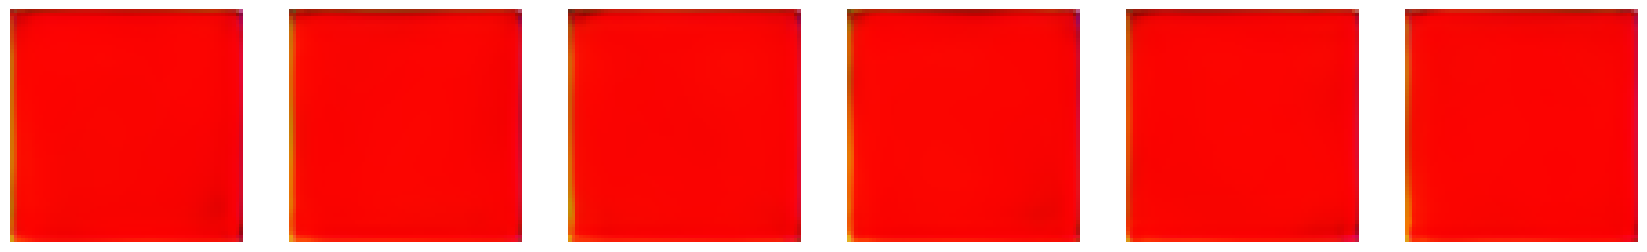

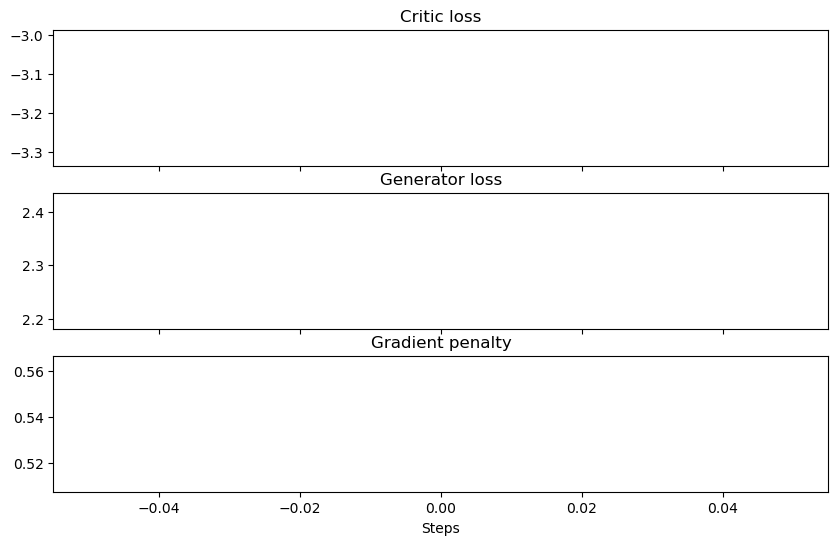

Step 30: g_loss -0.0305 critic_loss -2.4895 critic fake -0.1234  critic_real -2.3661 penalty 0.0042


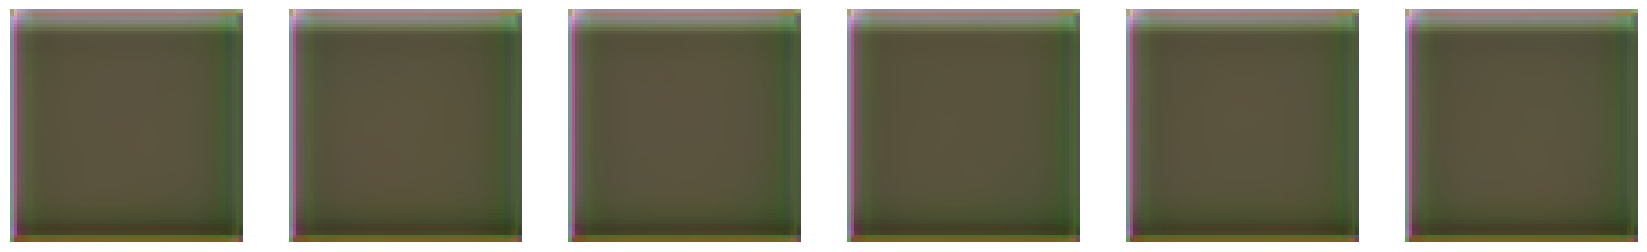

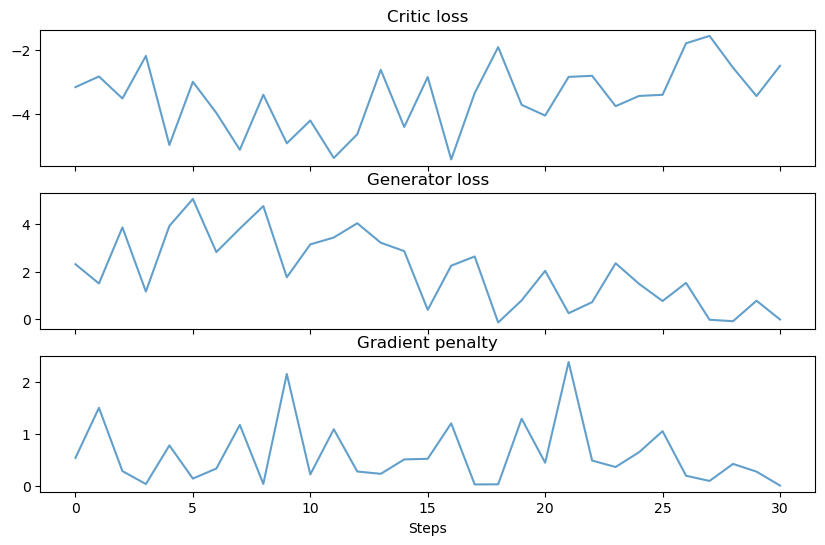

Step 60: g_loss 0.1729 critic_loss -1.9309 critic fake -0.2584  critic_real -1.6724 penalty 0.1243


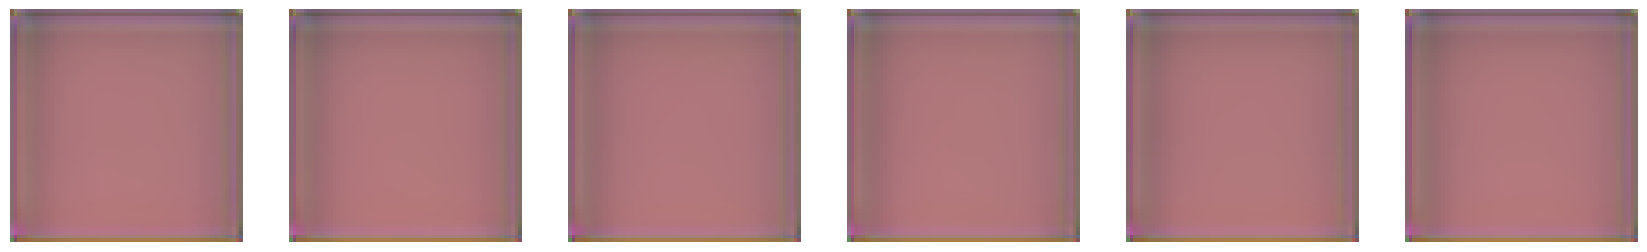

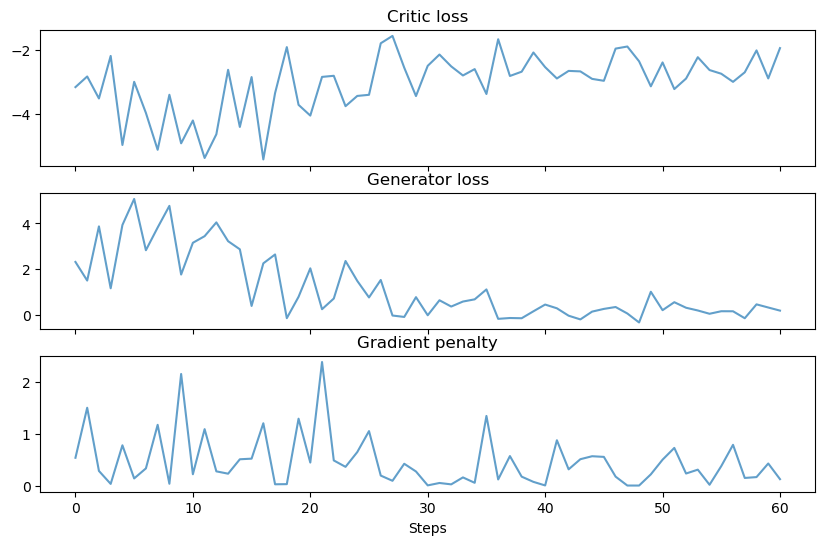

Step 90: g_loss 0.2492 critic_loss -3.2465 critic fake 0.0488  critic_real -3.2954 penalty 0.5166


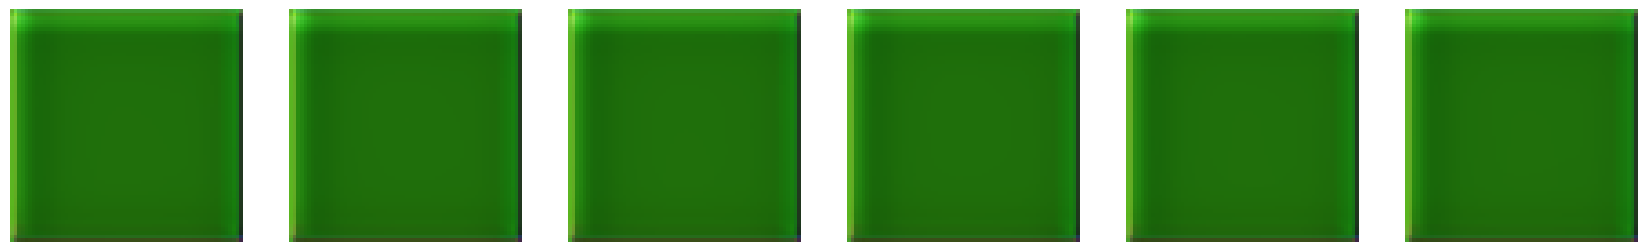

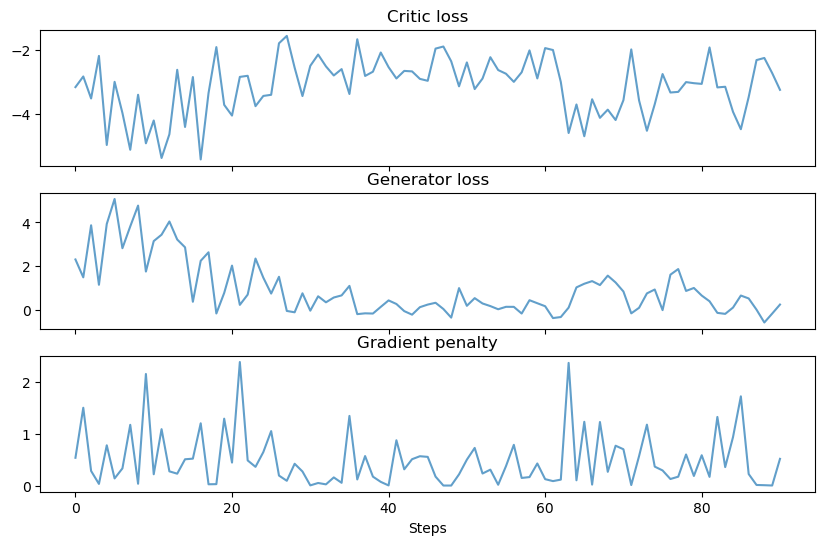

Step 120: g_loss 0.0237 critic_loss -3.1990 critic fake 0.2801  critic_real -3.4791 penalty 0.6880


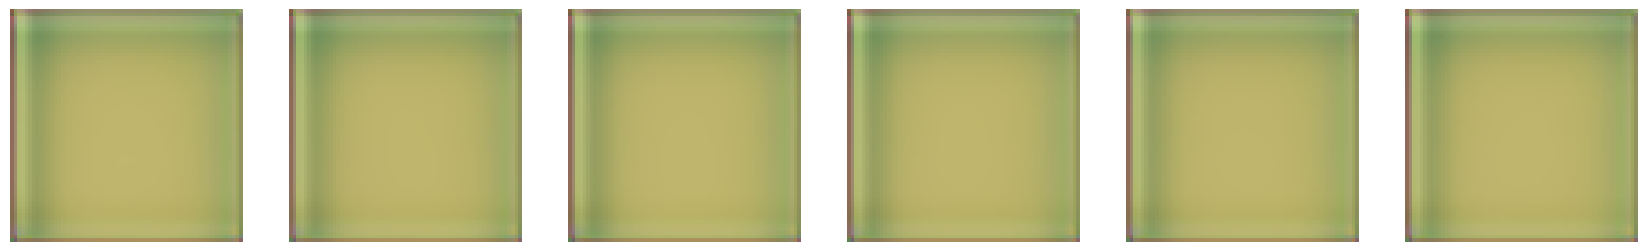

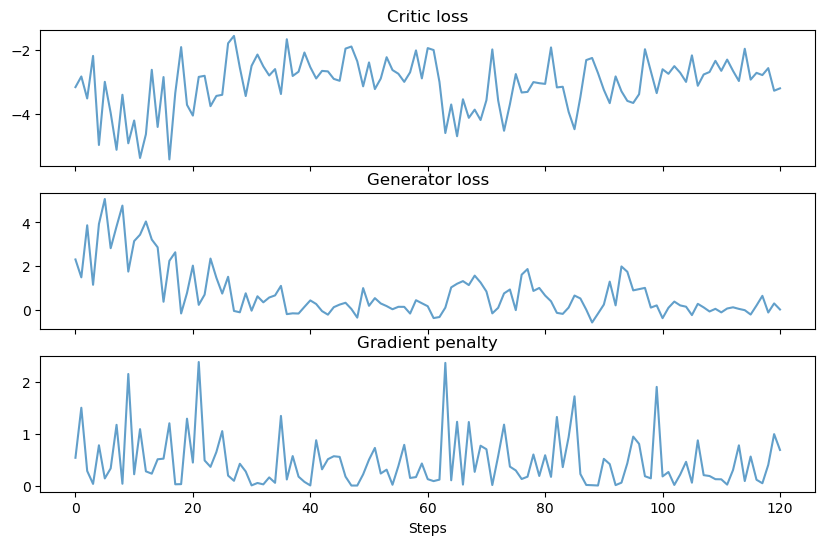

Step 150: g_loss -0.0665 critic_loss -2.8241 critic fake 0.2100  critic_real -3.0340 penalty 0.6494


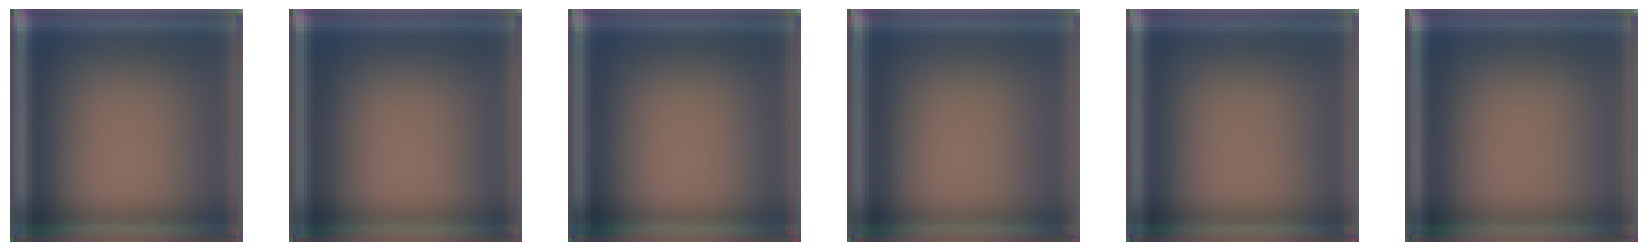

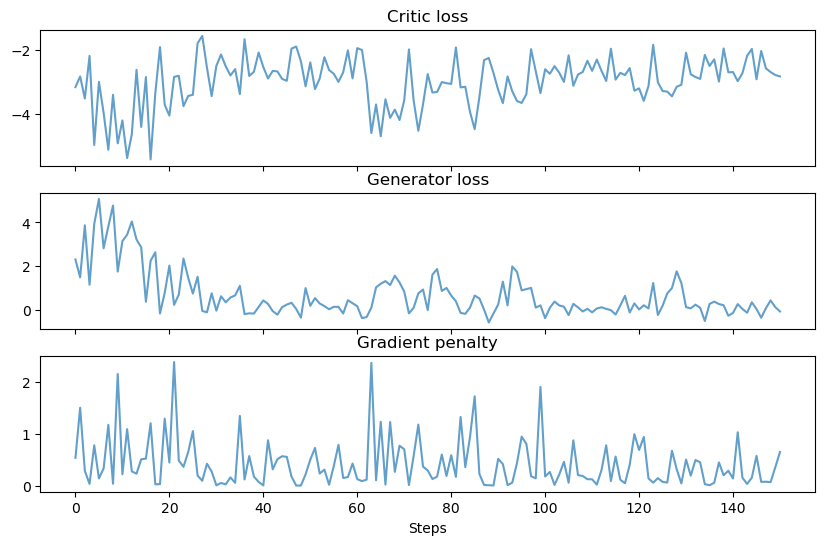

Step 180: g_loss 1.0521 critic_loss -1.9700 critic fake -0.6667  critic_real -1.3033 penalty 0.1653


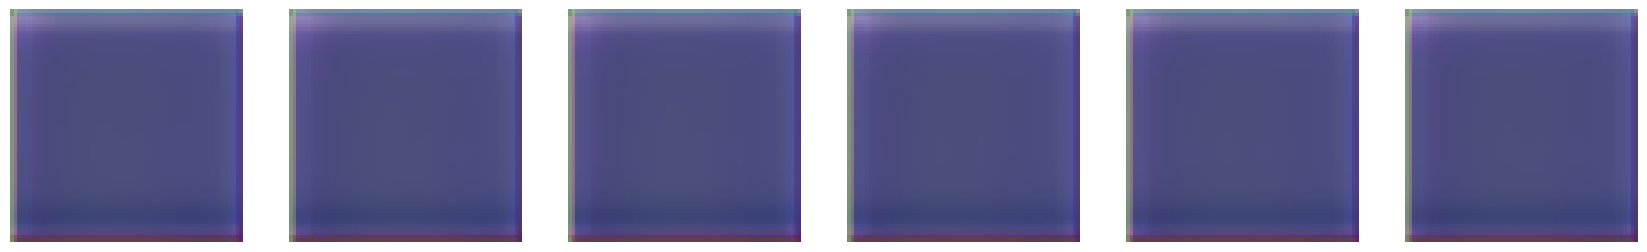

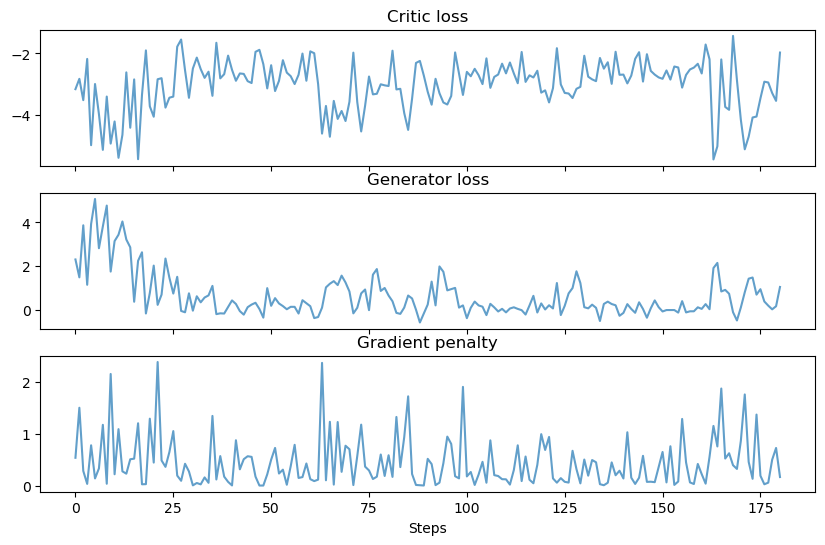

Step 210: g_loss -0.3199 critic_loss -2.4728 critic fake 0.3027  critic_real -2.7755 penalty 0.0330


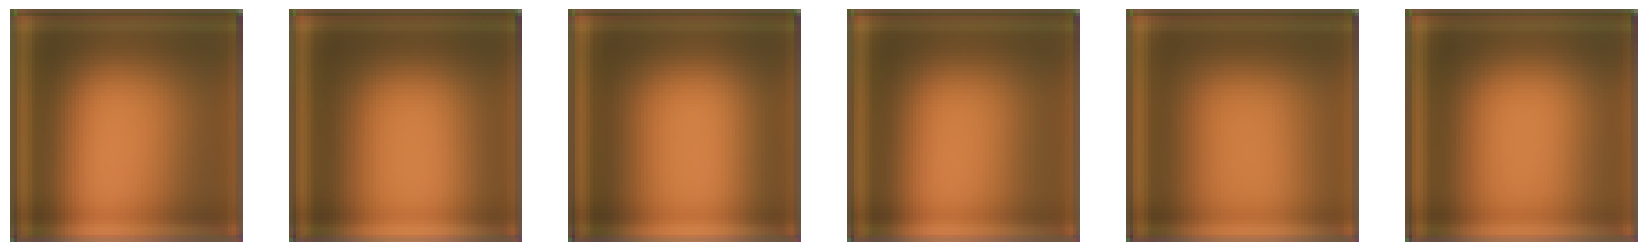

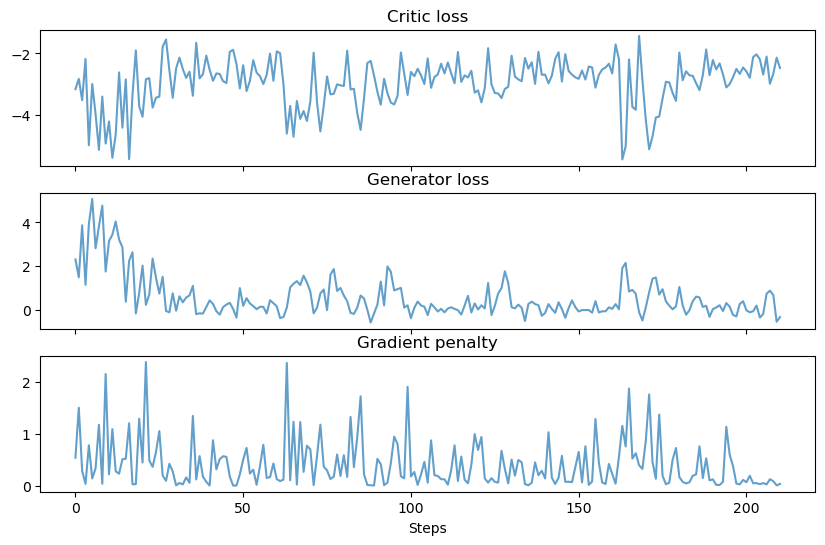

Step 240: g_loss 0.1944 critic_loss -2.2083 critic fake -0.5113  critic_real -1.6970 penalty 0.5510


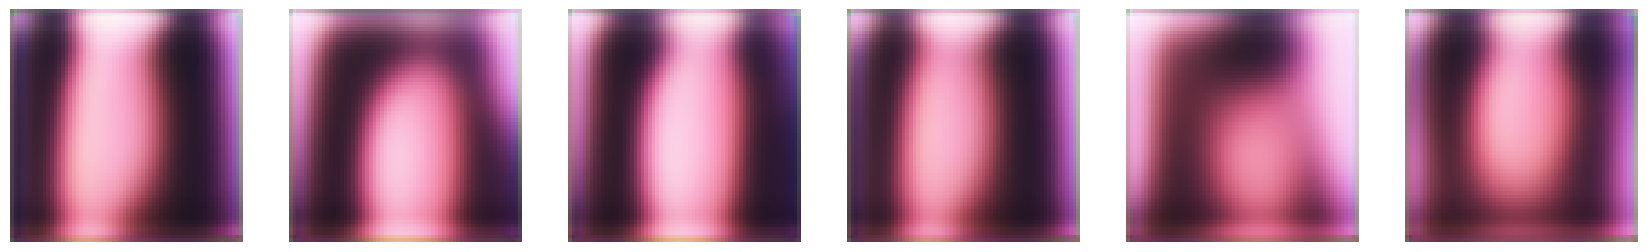

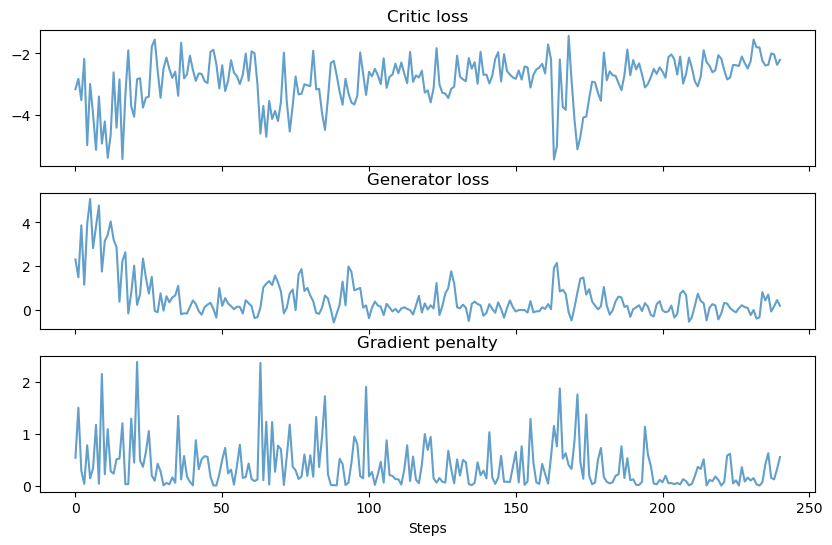

Step 270: g_loss -0.1173 critic_loss -1.4902 critic fake 0.3251  critic_real -1.8153 penalty 0.2863


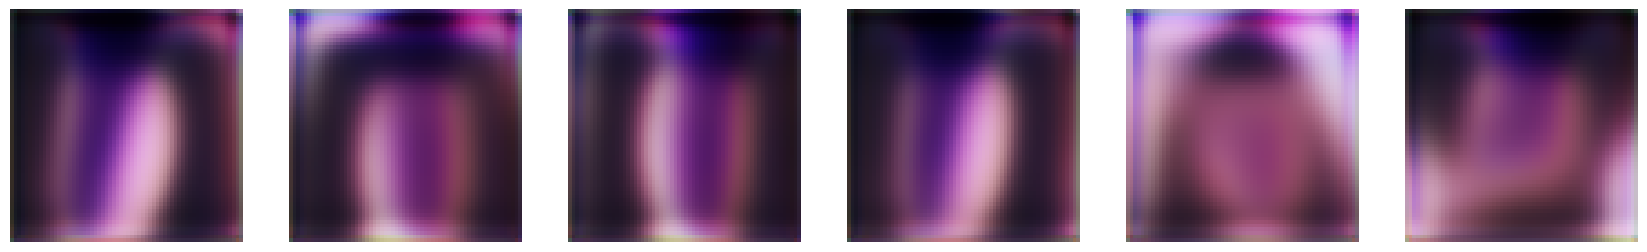

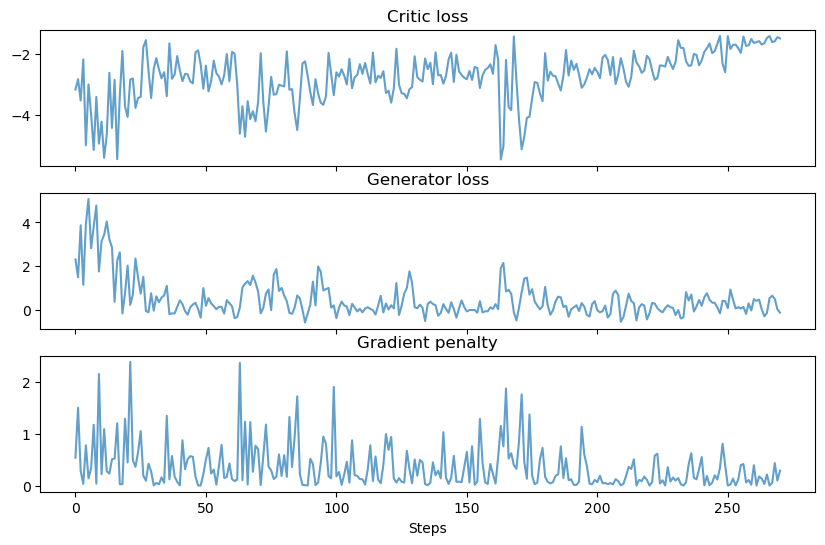

Step 300: g_loss -0.0418 critic_loss -1.4266 critic fake 0.0134  critic_real -1.4399 penalty 0.0108


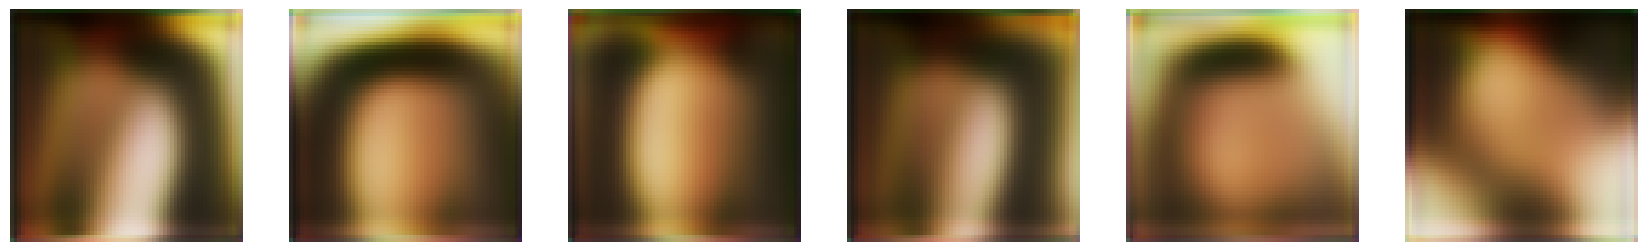

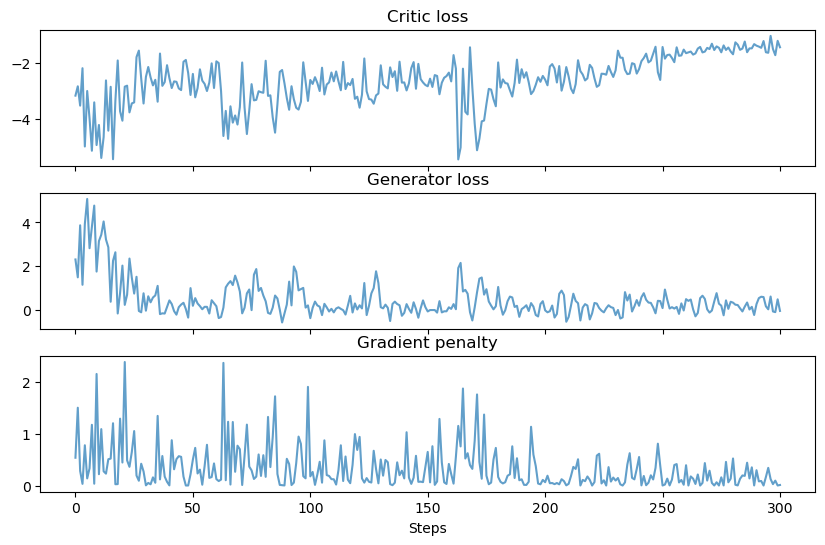

Step 330: g_loss 0.1758 critic_loss -1.3149 critic fake -0.0149  critic_real -1.3001 penalty 0.1420


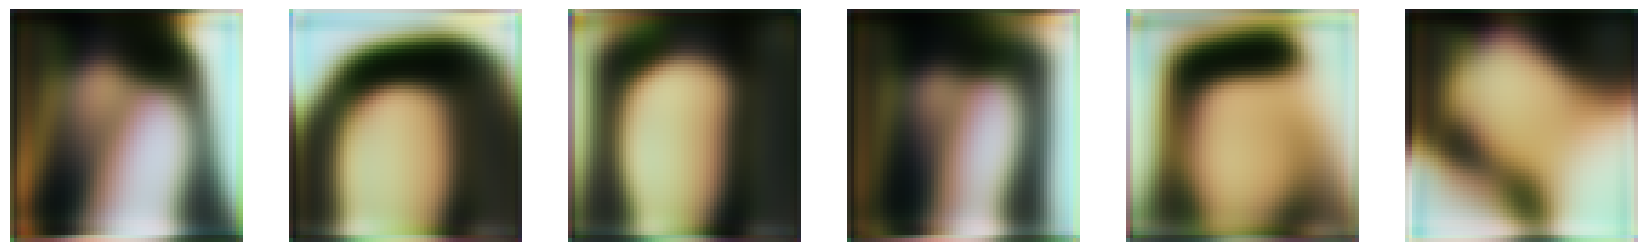

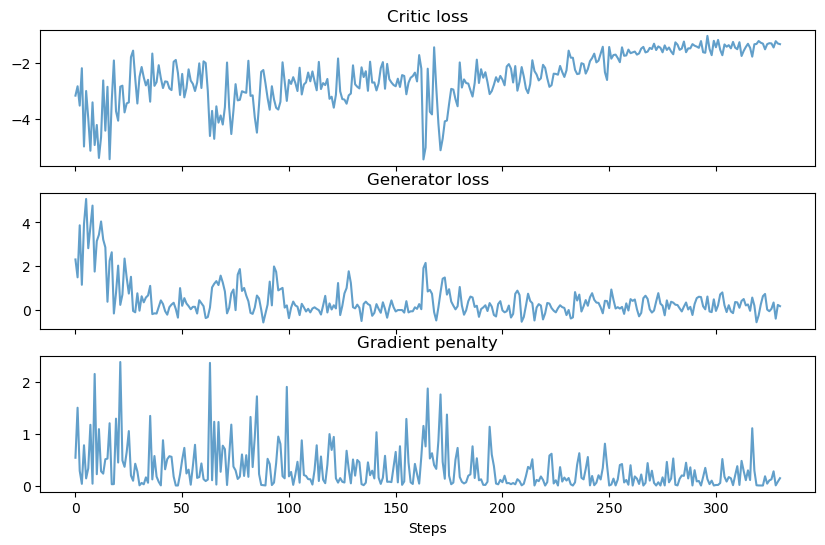

Step 360: g_loss -0.0868 critic_loss -1.2095 critic fake -0.1947  critic_real -1.0148 penalty 0.0240


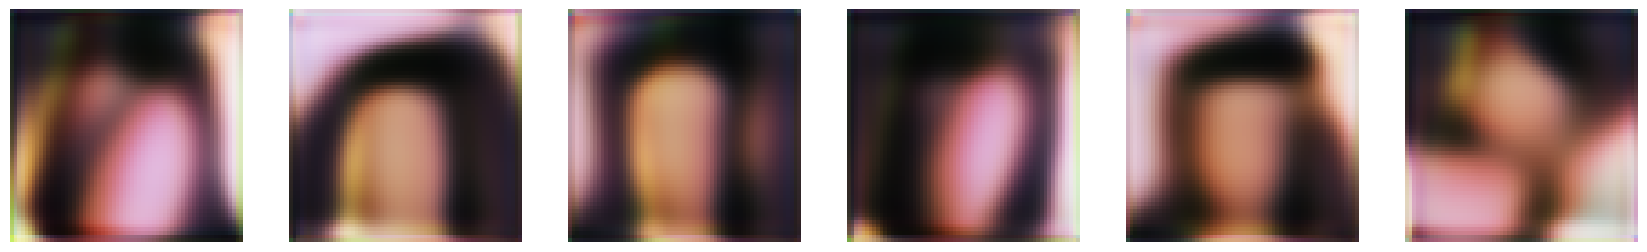

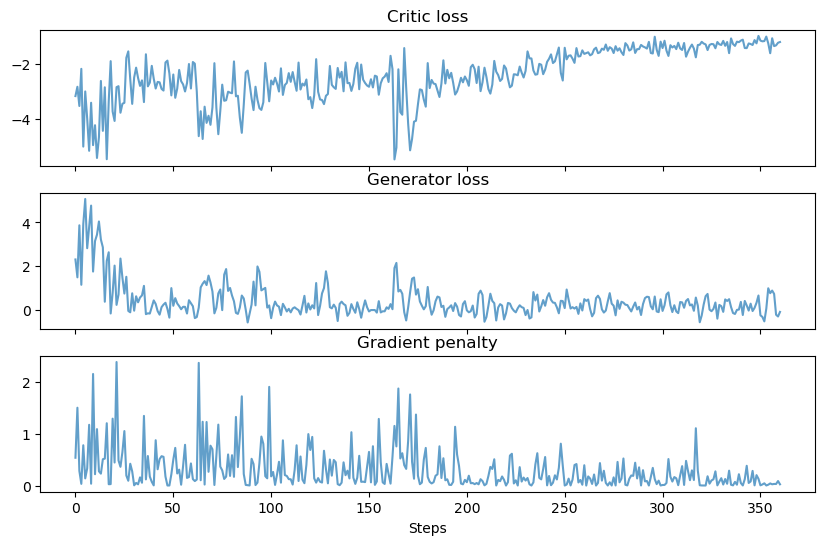

Step 390: g_loss 0.1135 critic_loss -1.0430 critic fake -0.1723  critic_real -0.8707 penalty 0.0509


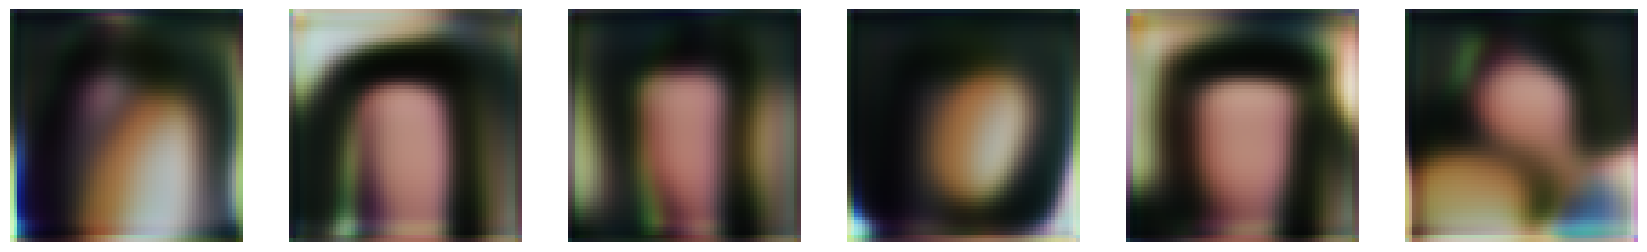

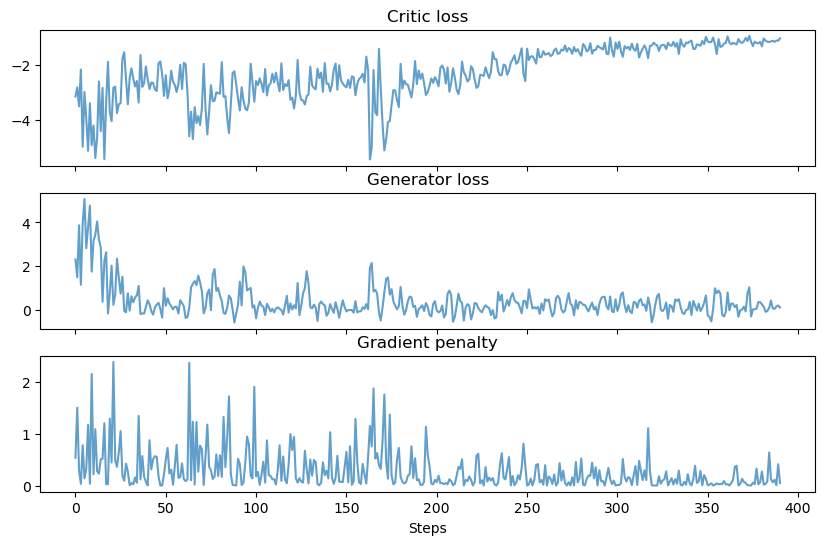

Step 420: g_loss 0.2020 critic_loss -1.0466 critic fake -0.2476  critic_real -0.7989 penalty 0.0028


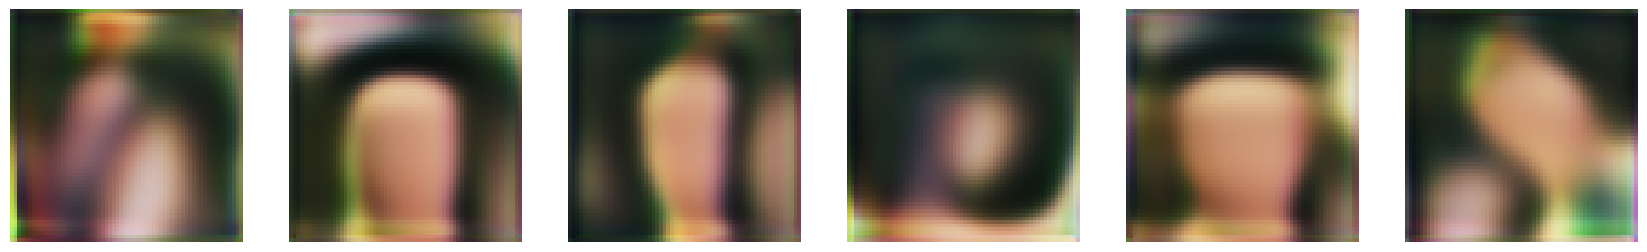

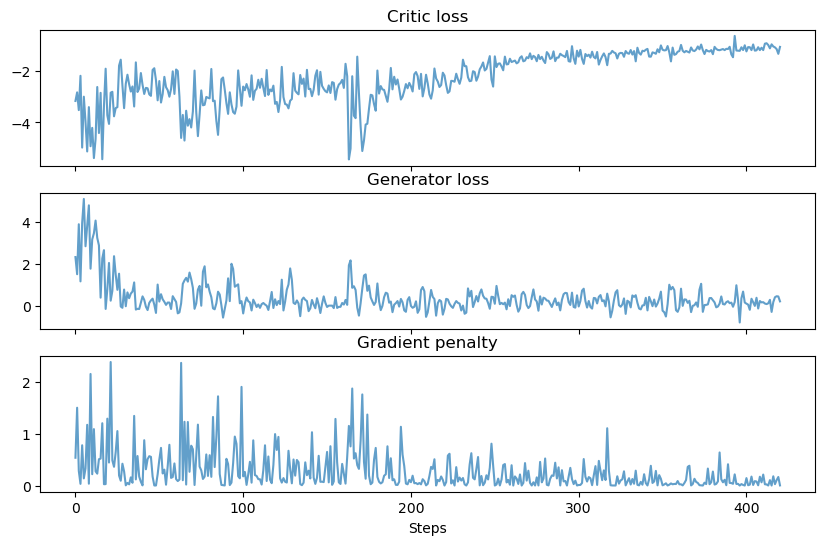

Step 450: g_loss 0.0456 critic_loss -0.8494 critic fake 0.0492  critic_real -0.8987 penalty 0.0304


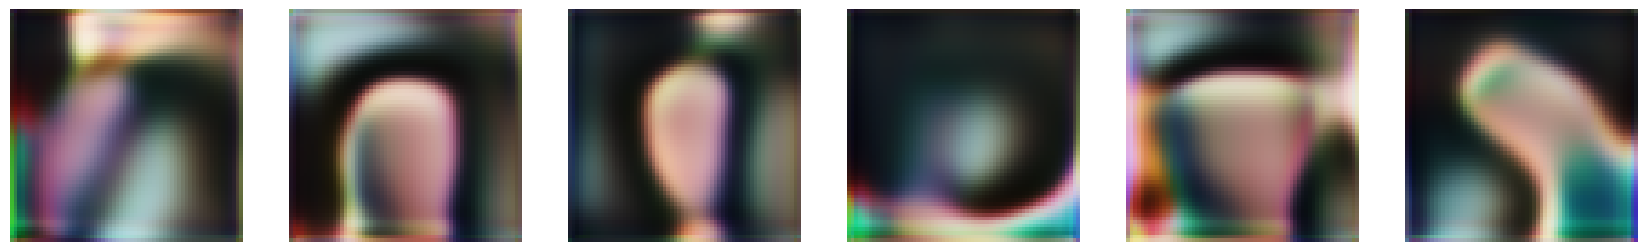

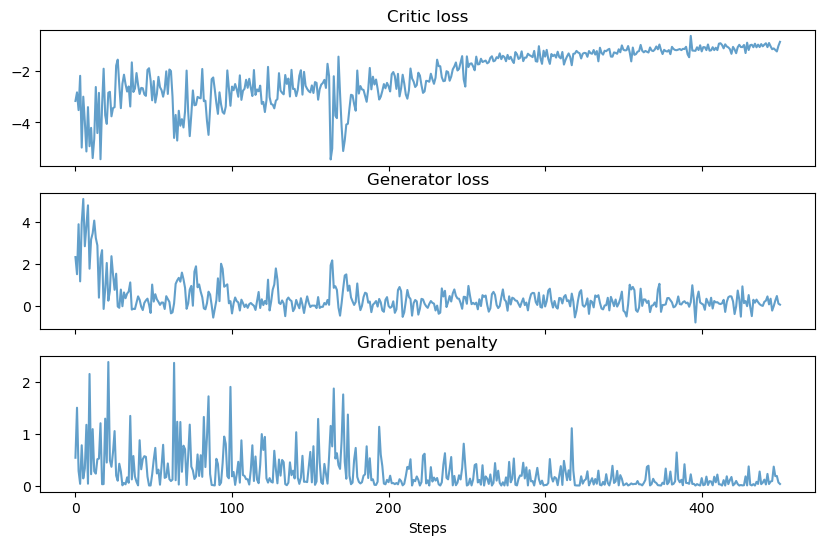

Step 480: g_loss 0.4487 critic_loss -1.1523 critic fake -0.8744  critic_real -0.2779 penalty 0.1403


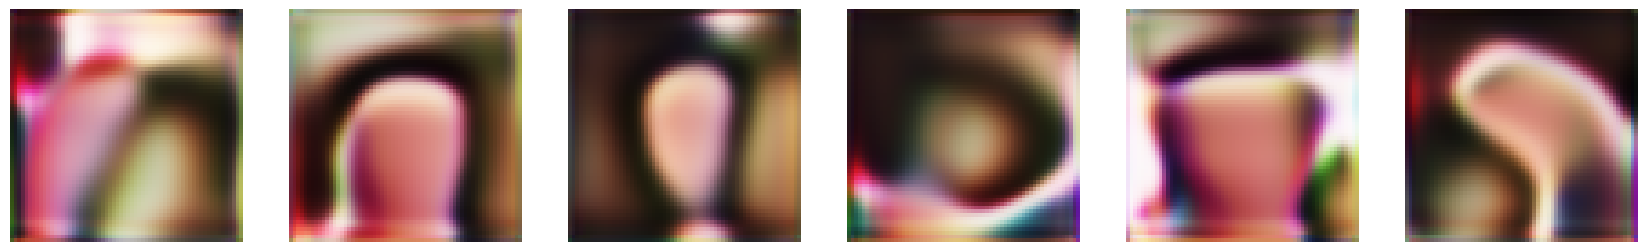

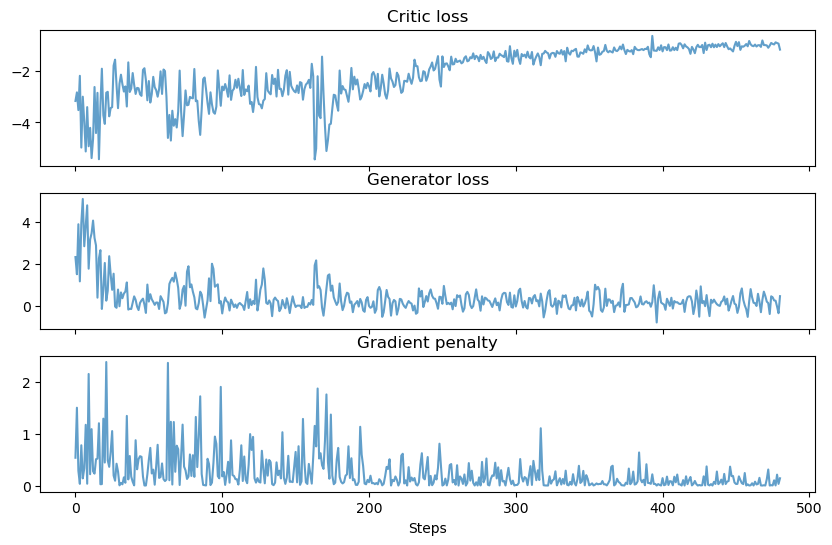

Step 510: g_loss 0.0090 critic_loss -0.9206 critic fake 0.0598  critic_real -0.9804 penalty 0.2580


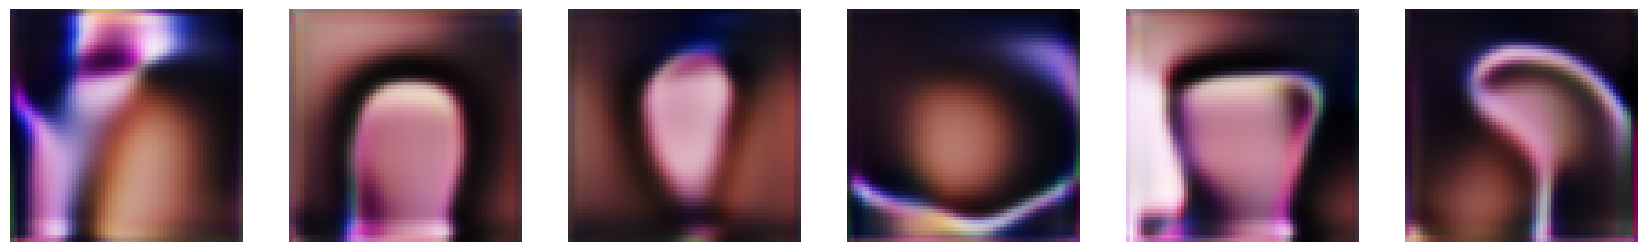

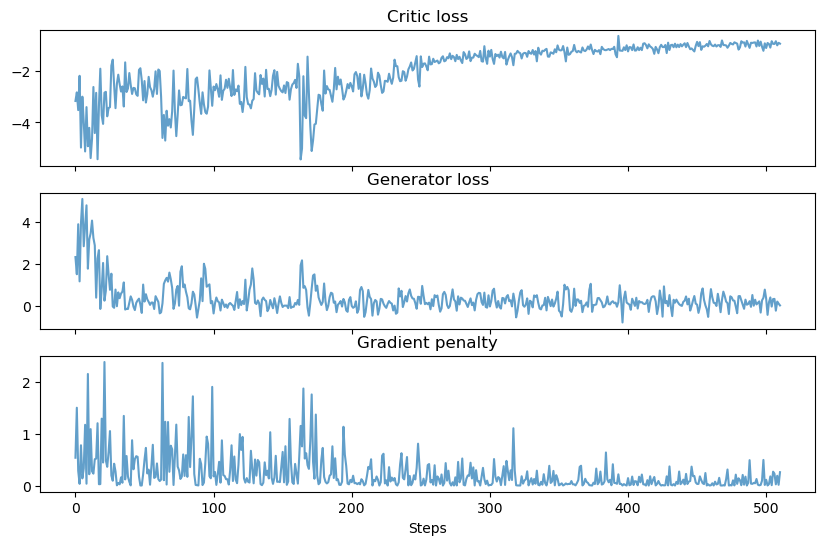

Step 540: g_loss 0.1337 critic_loss -0.9772 critic fake -0.2792  critic_real -0.6980 penalty 0.0360


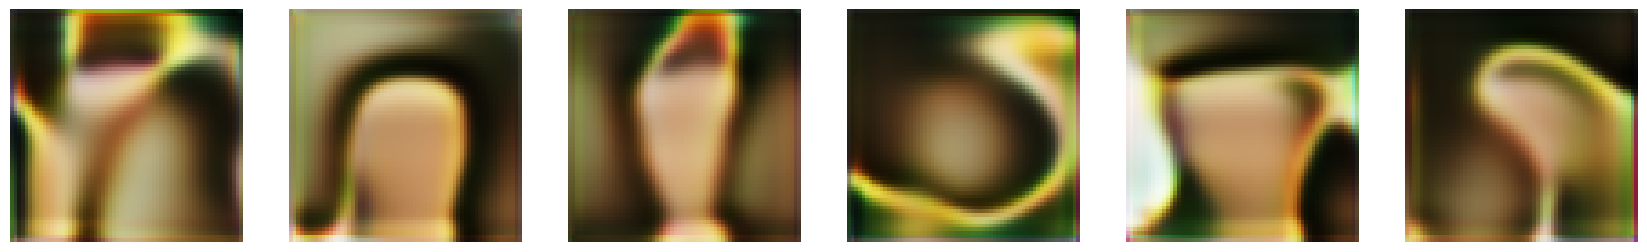

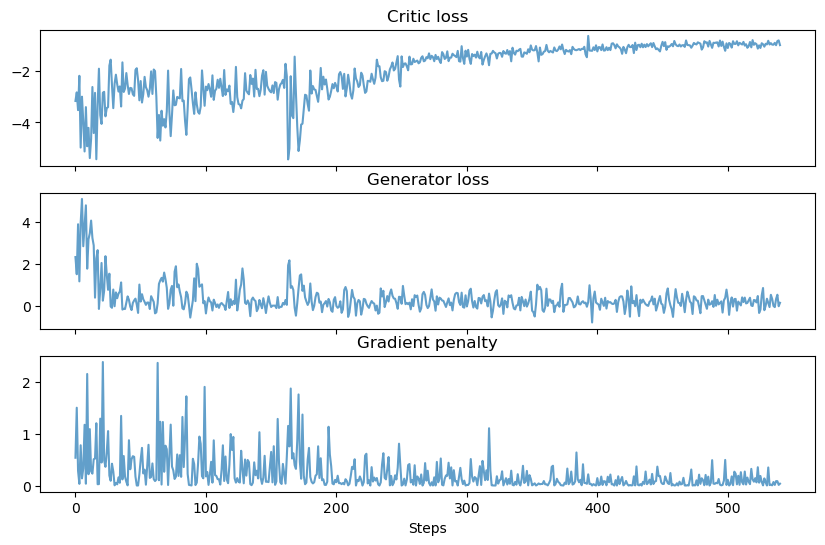

Step 570: g_loss 0.4570 critic_loss -0.8347 critic fake -0.4247  critic_real -0.4100 penalty 0.0055


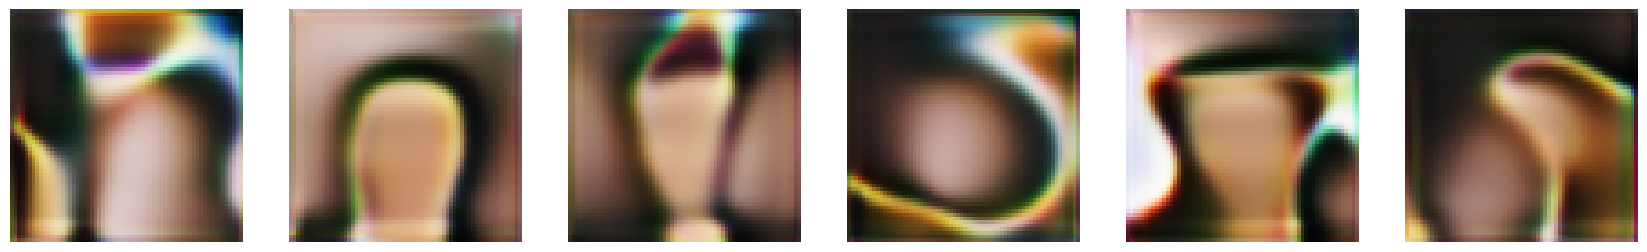

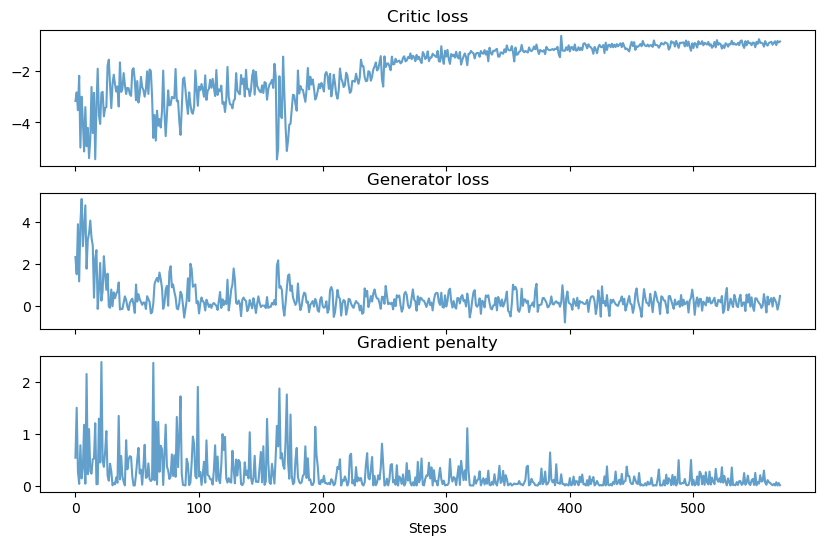

Step 600: g_loss 0.3654 critic_loss -0.8946 critic fake -0.4446  critic_real -0.4500 penalty 0.0434


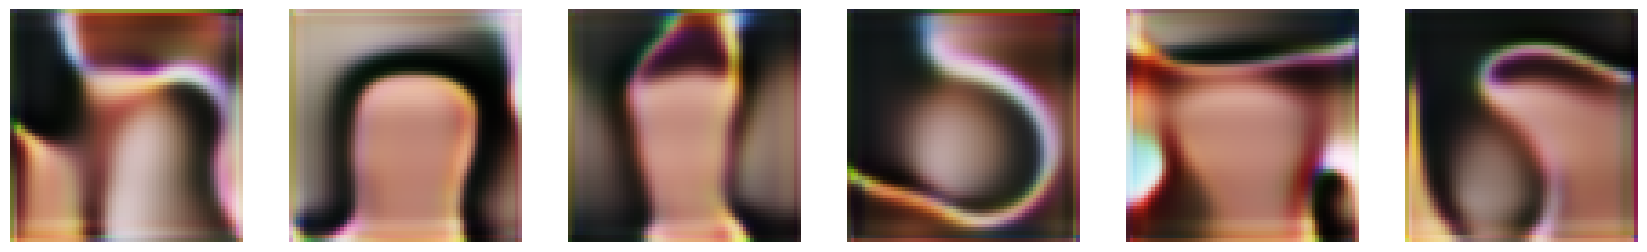

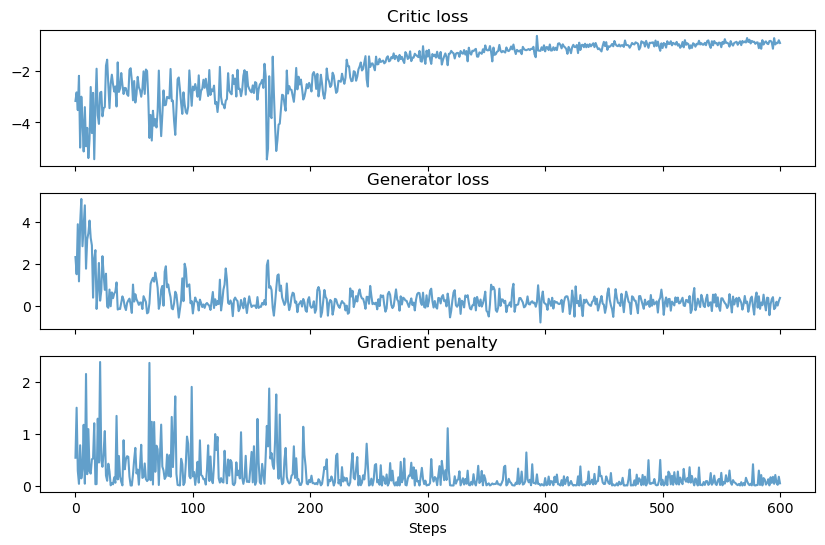

Step 630: g_loss -0.0598 critic_loss -0.9295 critic fake 0.6111  critic_real -1.5407 penalty 0.2074


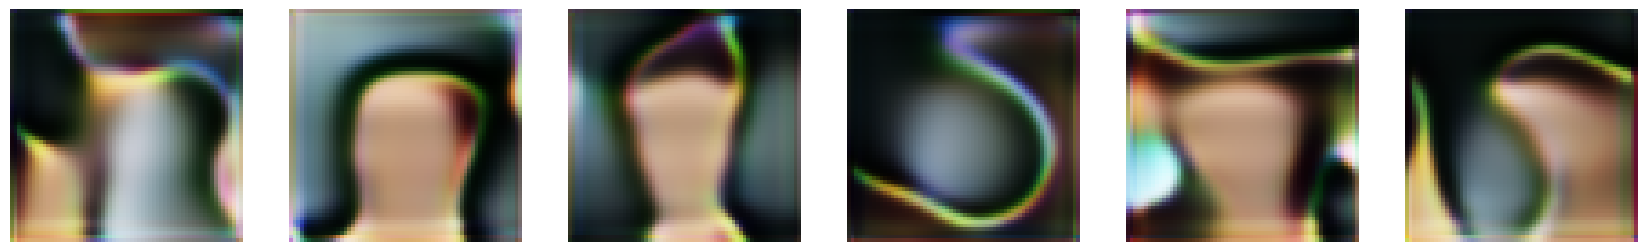

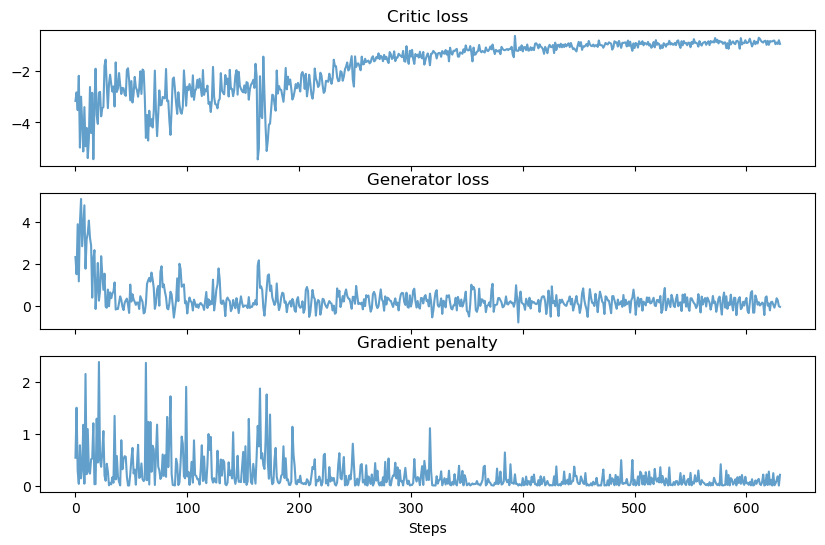

Step 660: g_loss 0.2434 critic_loss -0.8354 critic fake -0.4842  critic_real -0.3512 penalty 0.1991


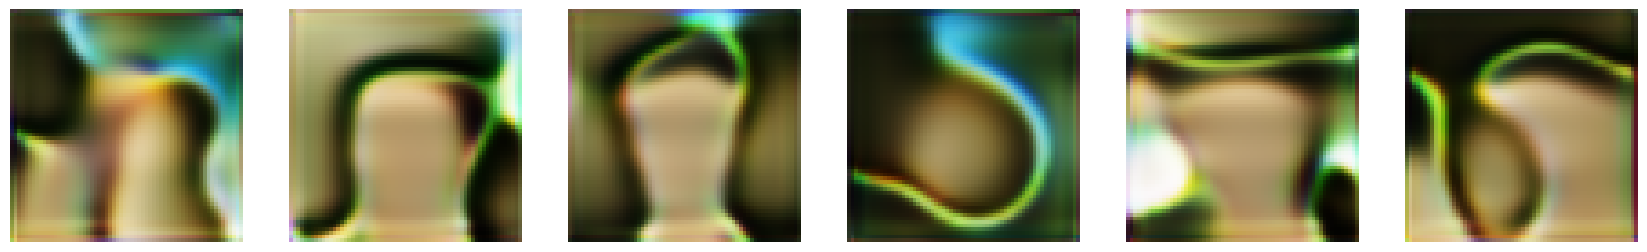

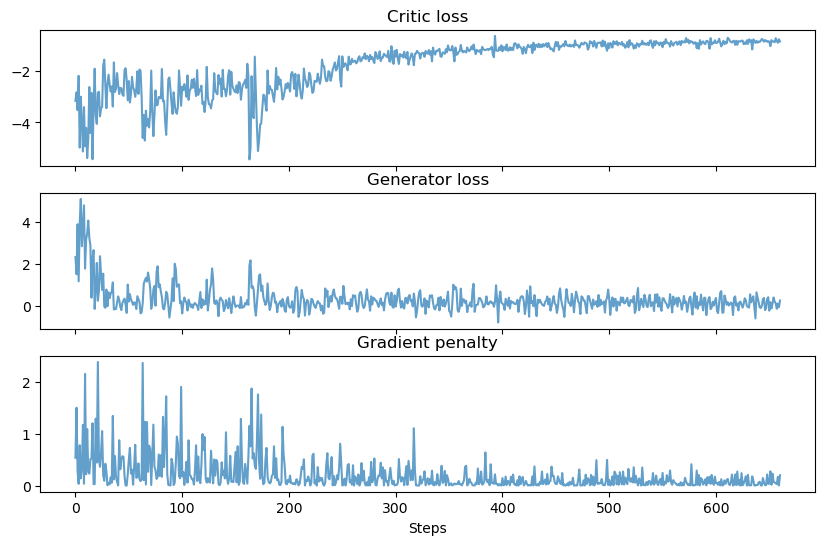

Step 690: g_loss 0.1215 critic_loss -0.7511 critic fake -0.2704  critic_real -0.4806 penalty 0.0261


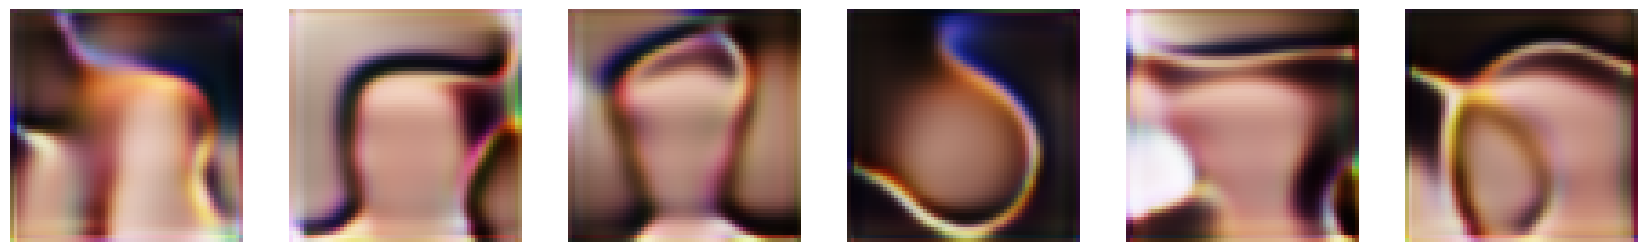

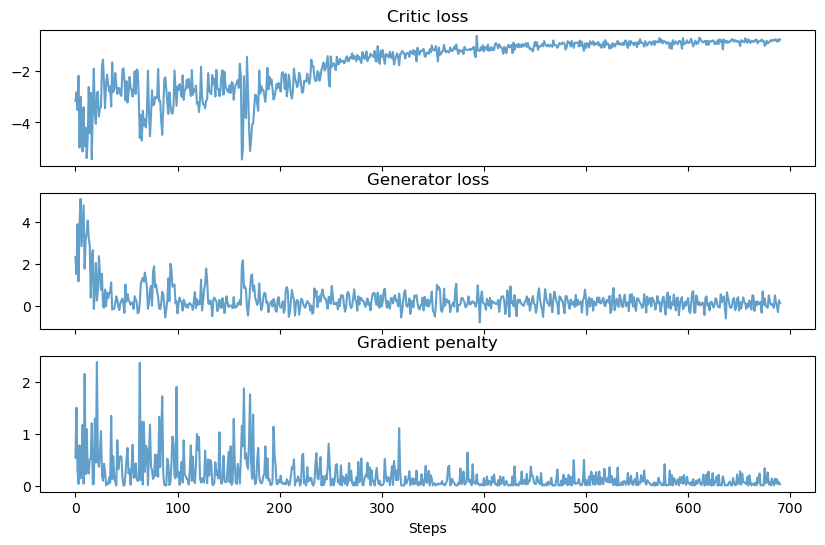

Step 720: g_loss 0.6596 critic_loss -0.8009 critic fake -0.6916  critic_real -0.1094 penalty 0.0397


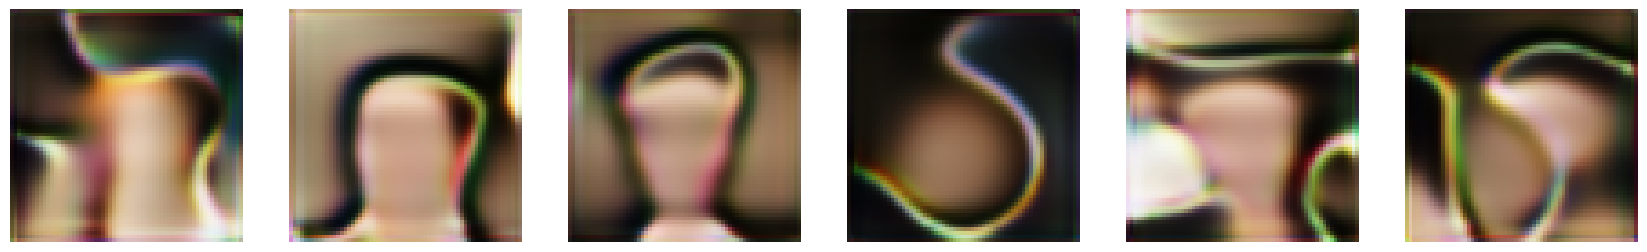

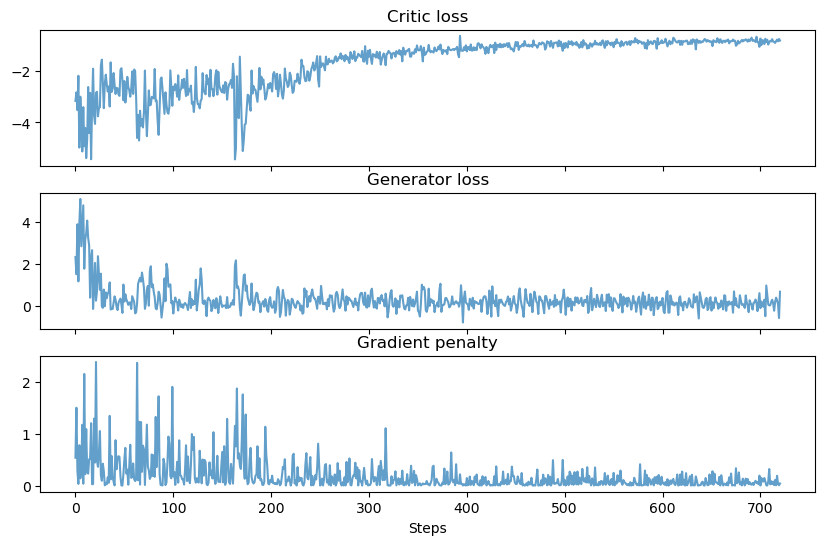

Step 750: g_loss 0.3434 critic_loss -0.7763 critic fake -0.2670  critic_real -0.5093 penalty 0.0119


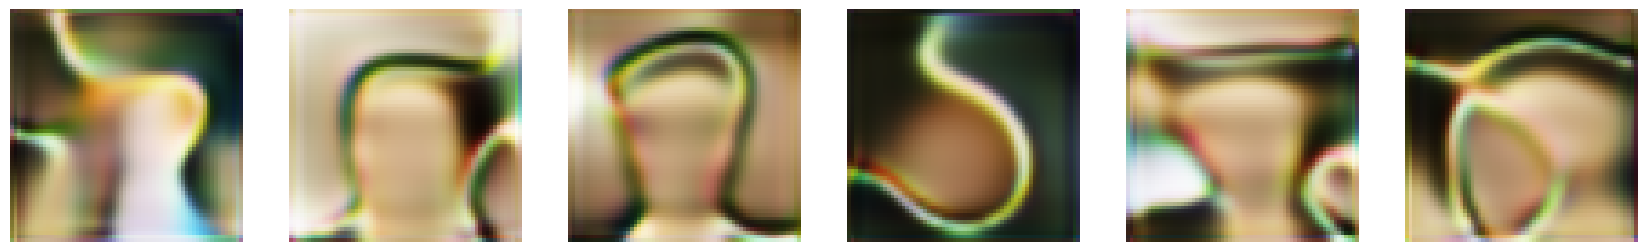

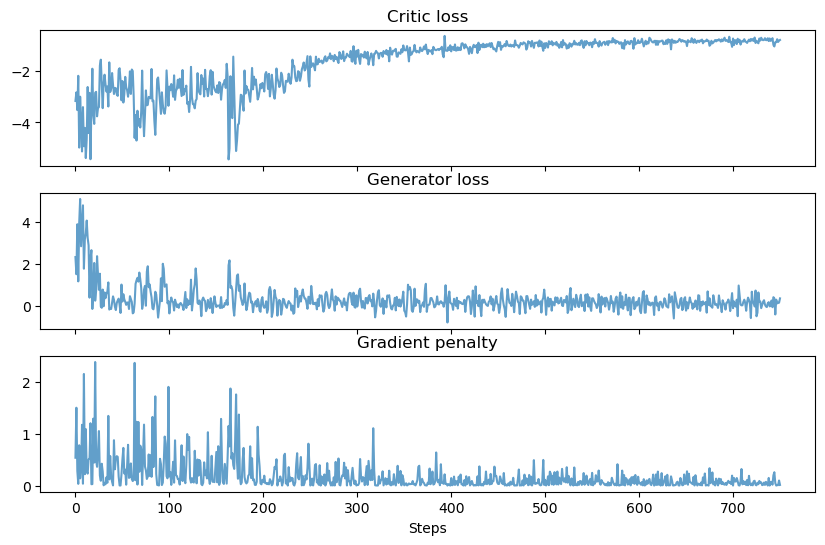

Step 780: g_loss -0.6169 critic_loss -0.8128 critic fake 0.4638  critic_real -1.2766 penalty 0.0054


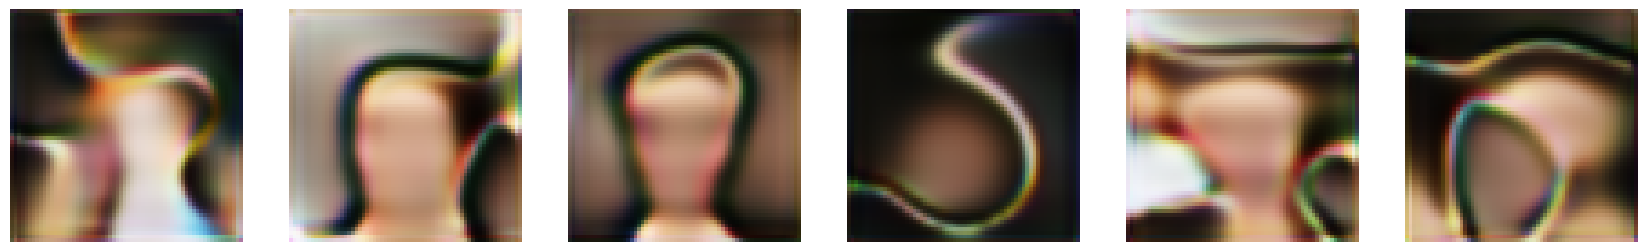

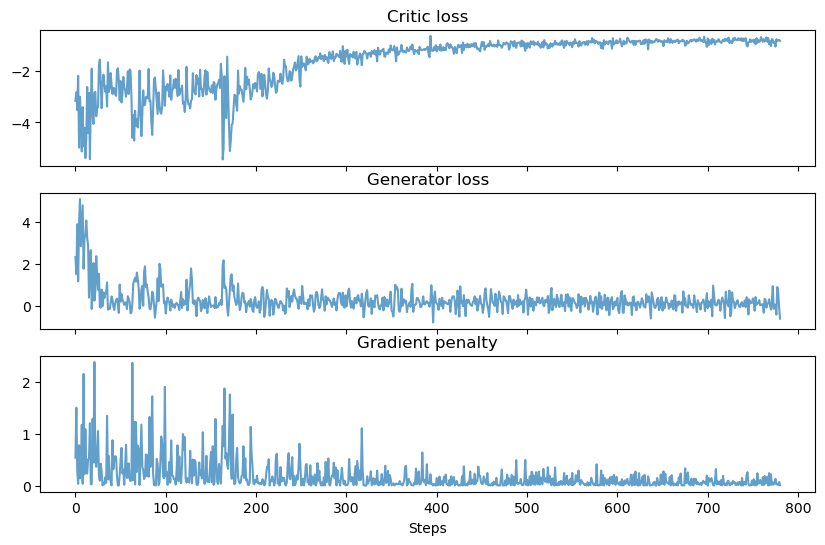

Step 810: g_loss 0.1636 critic_loss -0.8048 critic fake -0.1967  critic_real -0.6081 penalty 0.0648


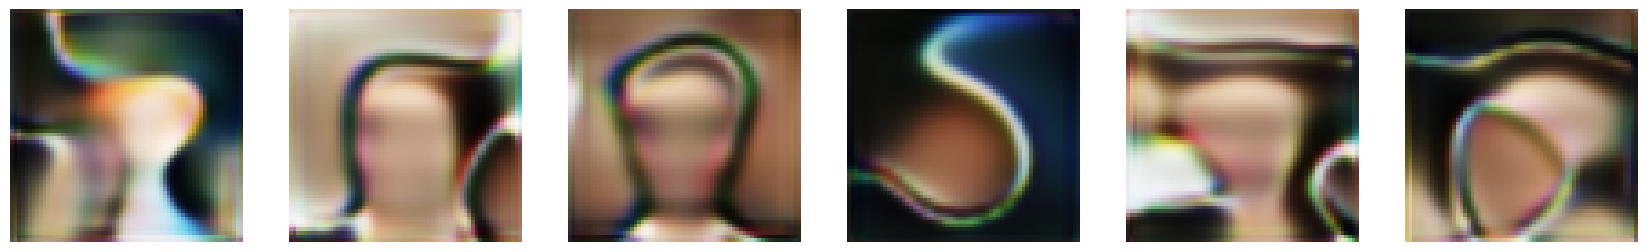

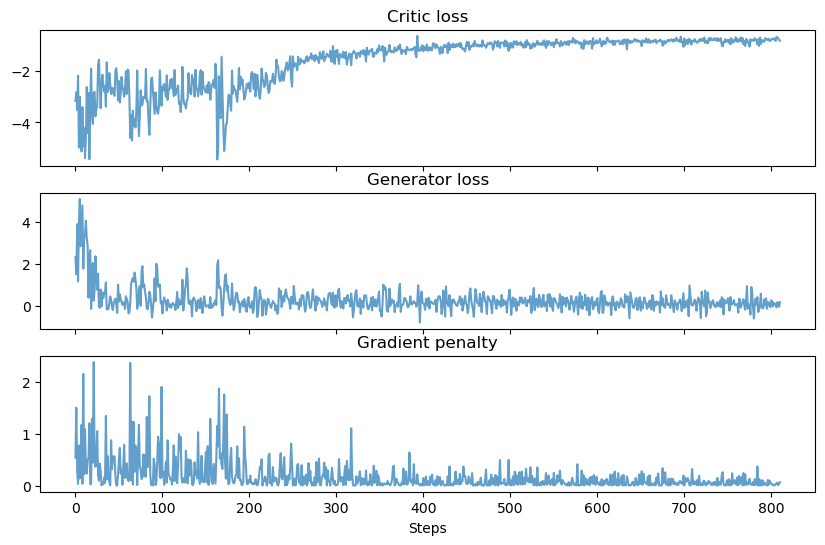

Step 840: g_loss 0.2547 critic_loss -0.7751 critic fake -0.0848  critic_real -0.6902 penalty 0.0571


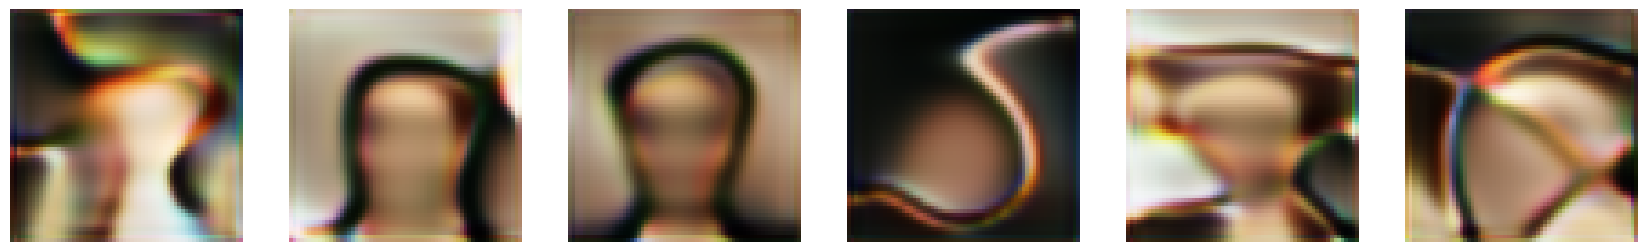

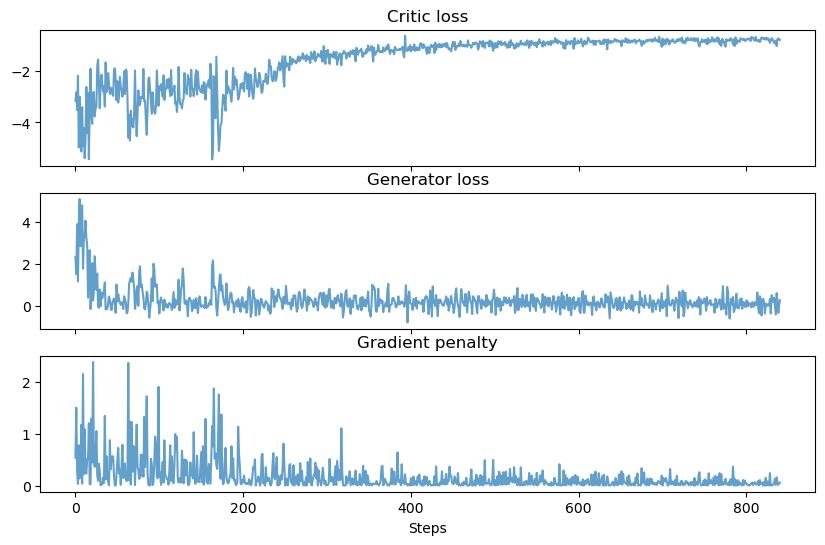

Step 870: g_loss 0.0799 critic_loss -0.7873 critic fake -0.0461  critic_real -0.7412 penalty 0.0871


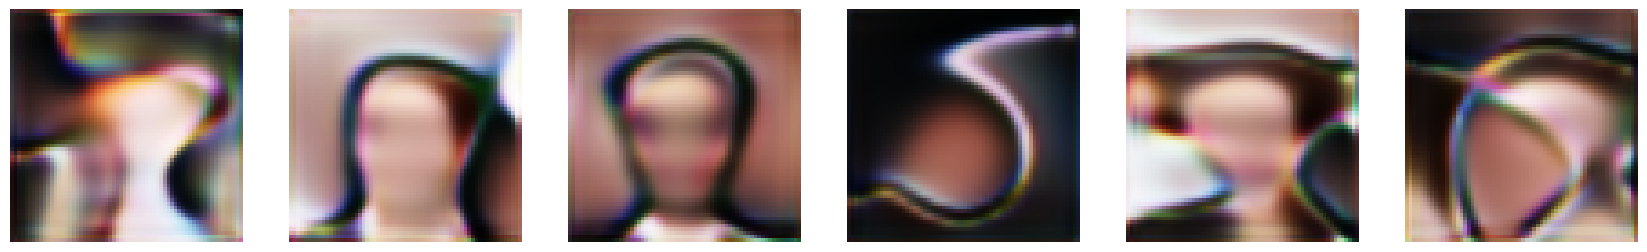

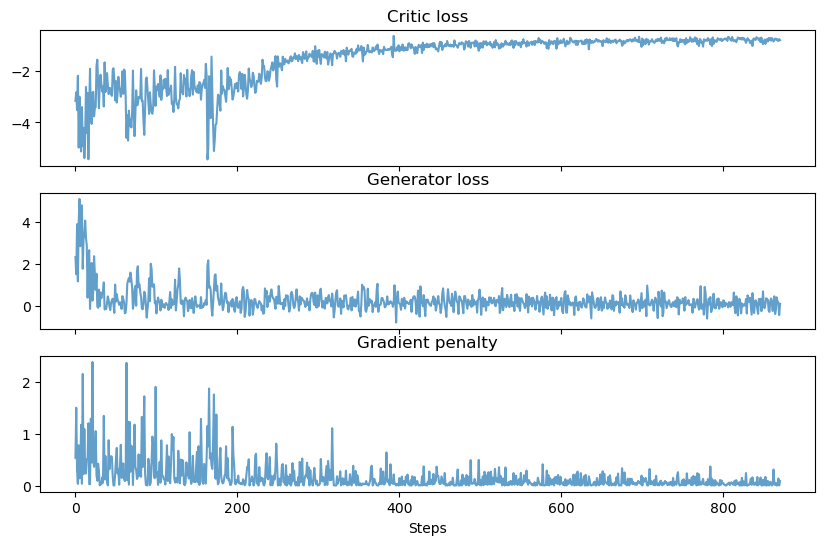

Step 900: g_loss 0.1849 critic_loss -0.7939 critic fake -0.0564  critic_real -0.7375 penalty 0.0069


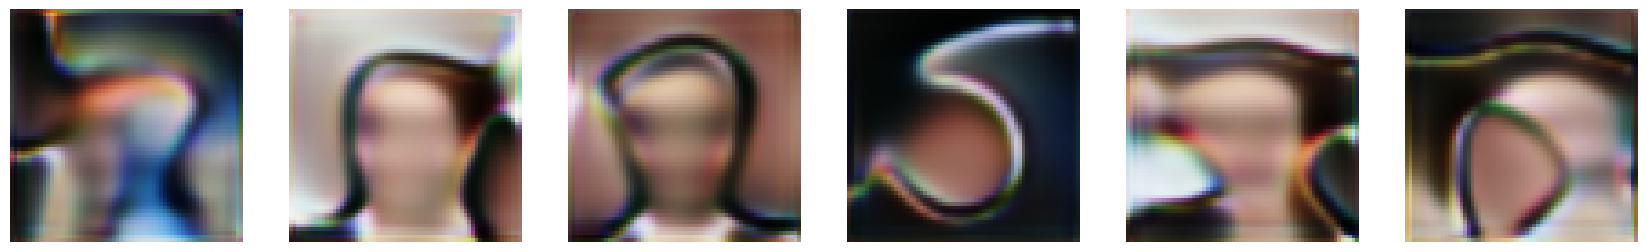

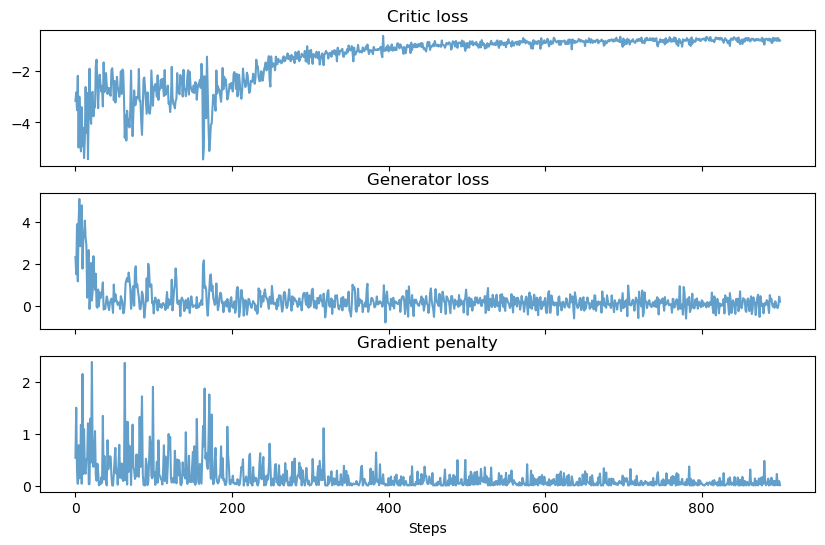

Step 930: g_loss -0.2543 critic_loss -0.6863 critic fake 0.0514  critic_real -0.7377 penalty 0.0507


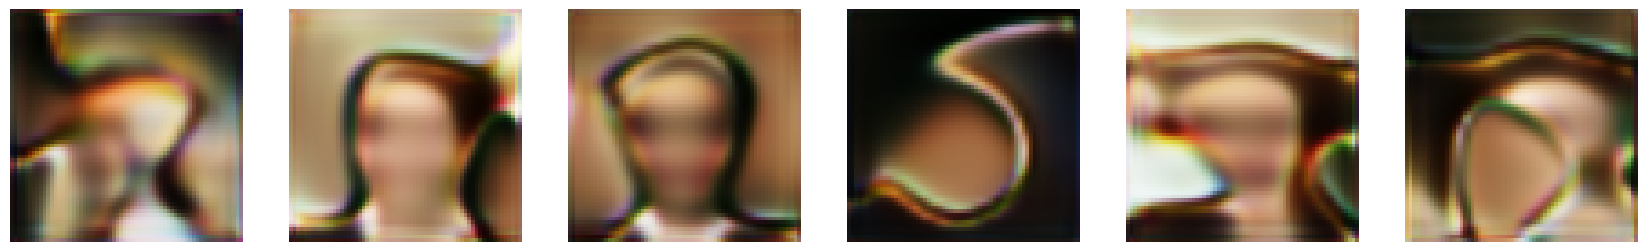

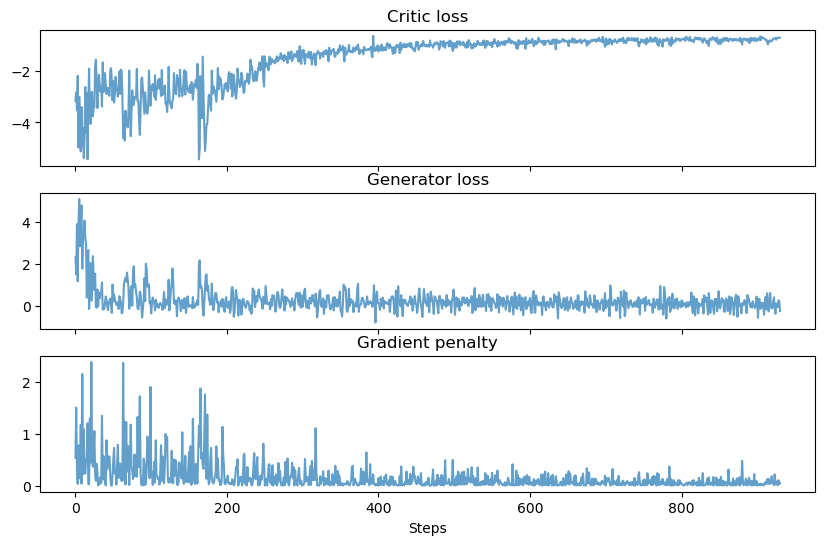

Step 960: g_loss 0.2849 critic_loss -0.7736 critic fake -0.2760  critic_real -0.4975 penalty 0.0661


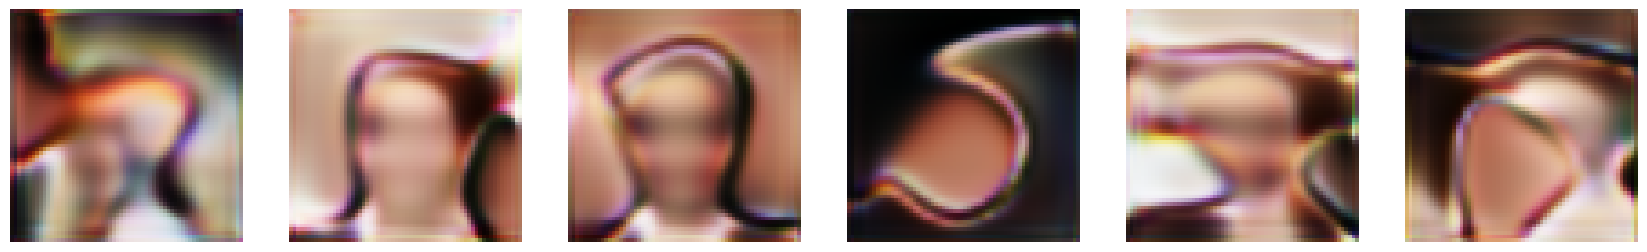

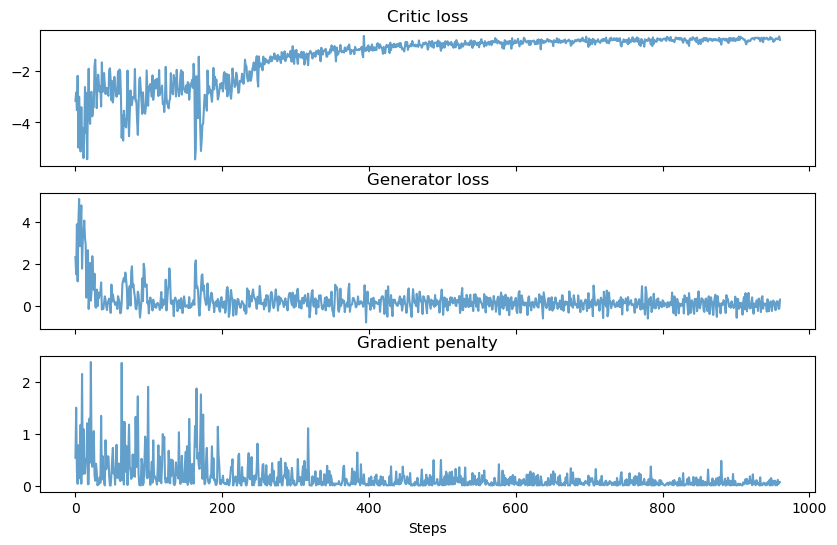

Step 990: g_loss -0.2152 critic_loss -0.7305 critic fake 0.2530  critic_real -0.9835 penalty 0.0382


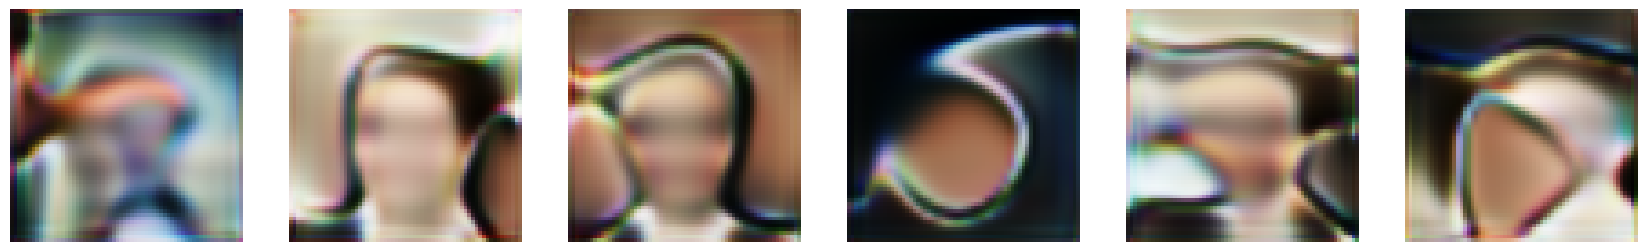

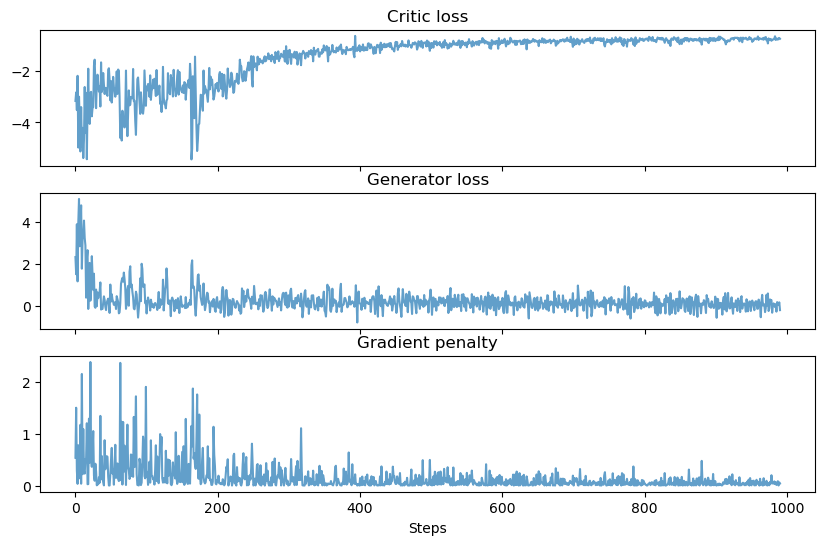

Step 1020: g_loss 0.4018 critic_loss -0.7525 critic fake -0.3401  critic_real -0.4124 penalty 0.1063


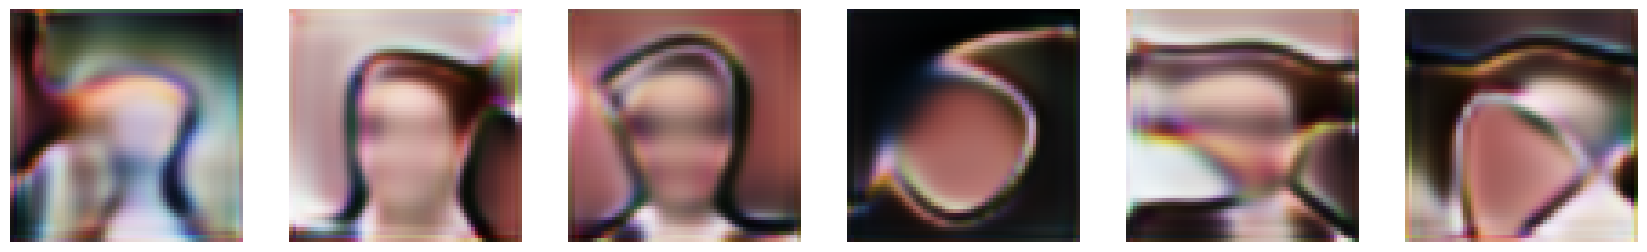

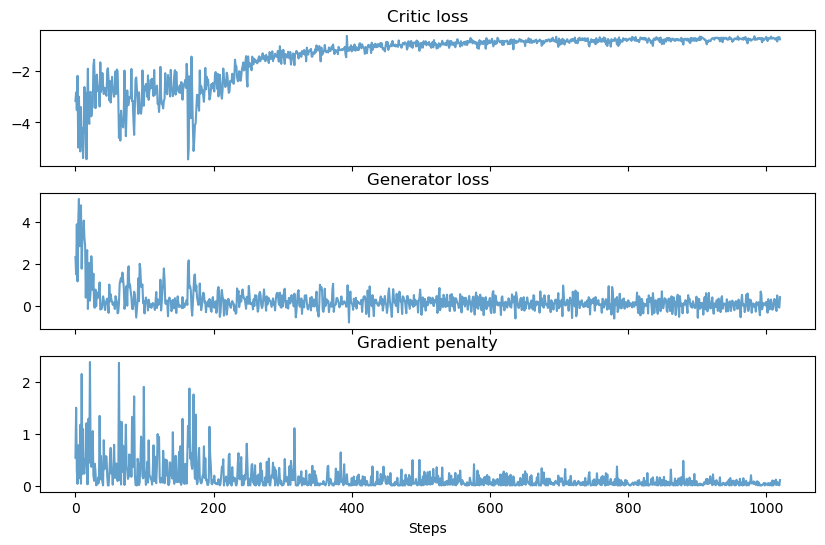

Step 1050: g_loss 0.0053 critic_loss -0.7806 critic fake -0.0800  critic_real -0.7006 penalty 0.0327


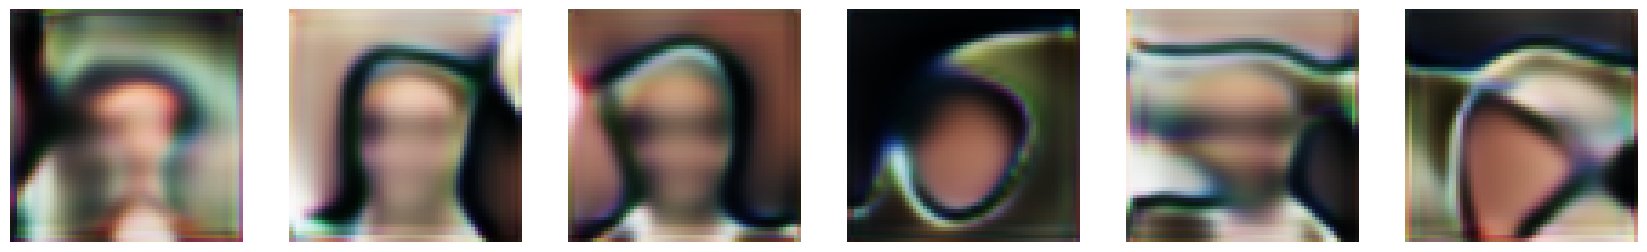

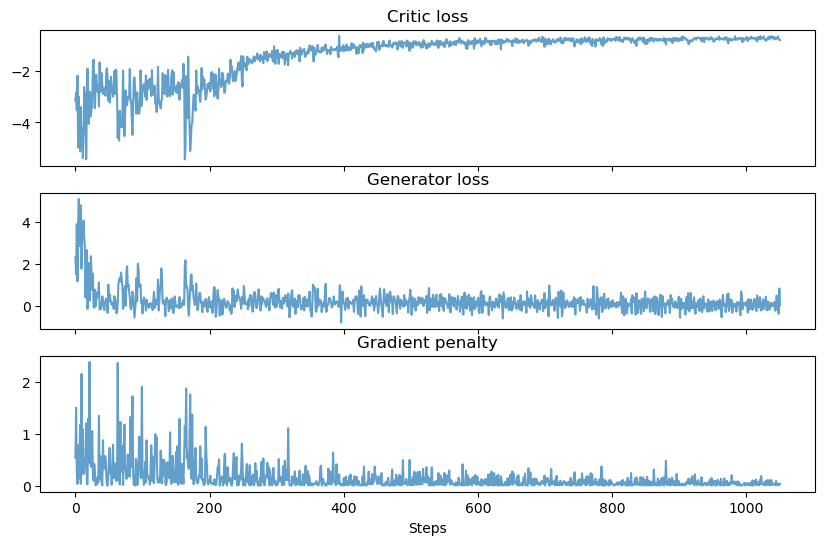

Step 1080: g_loss 0.1960 critic_loss -0.7013 critic fake -0.1185  critic_real -0.5829 penalty 0.0030


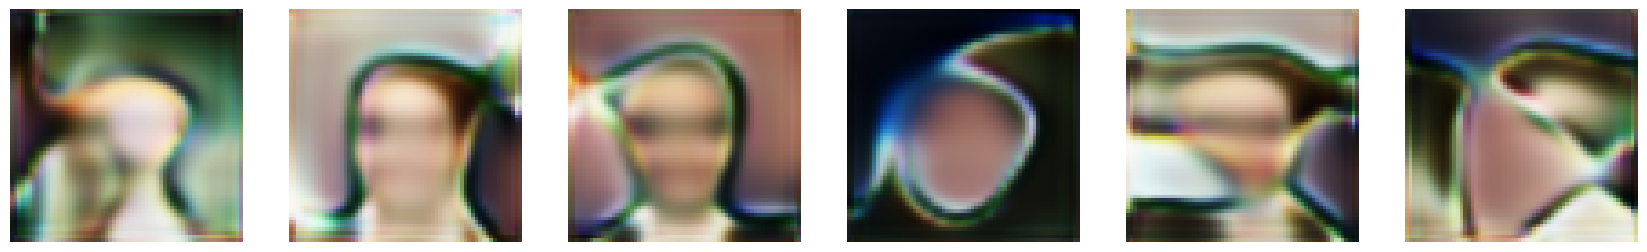

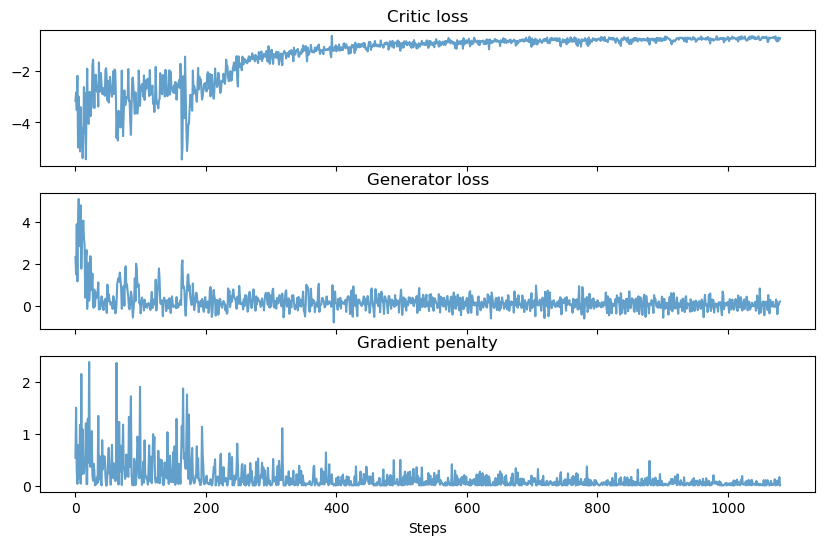

Step 1110: g_loss -0.1353 critic_loss -0.6871 critic fake 0.1693  critic_real -0.8564 penalty 0.0383


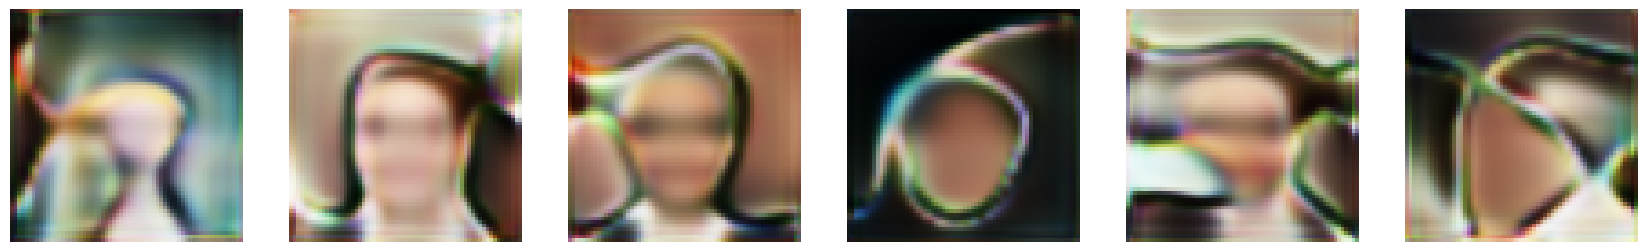

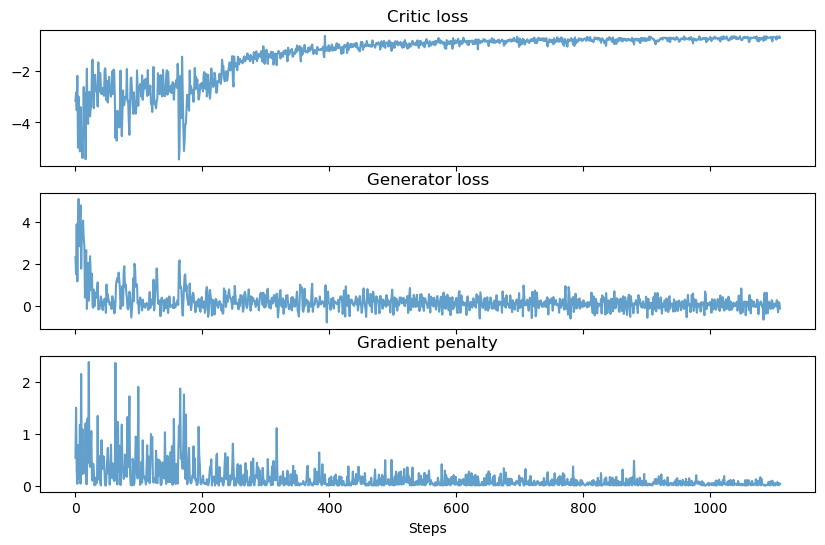

Step 1140: g_loss 0.1789 critic_loss -0.6388 critic fake -0.1953  critic_real -0.4435 penalty 0.0003


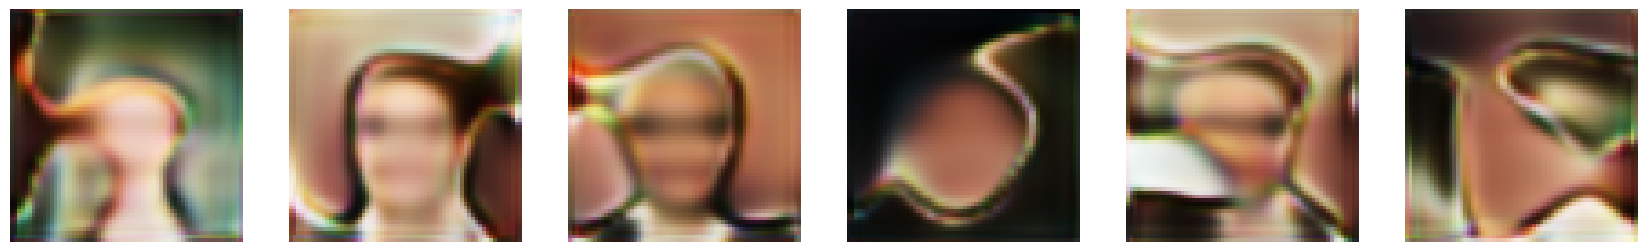

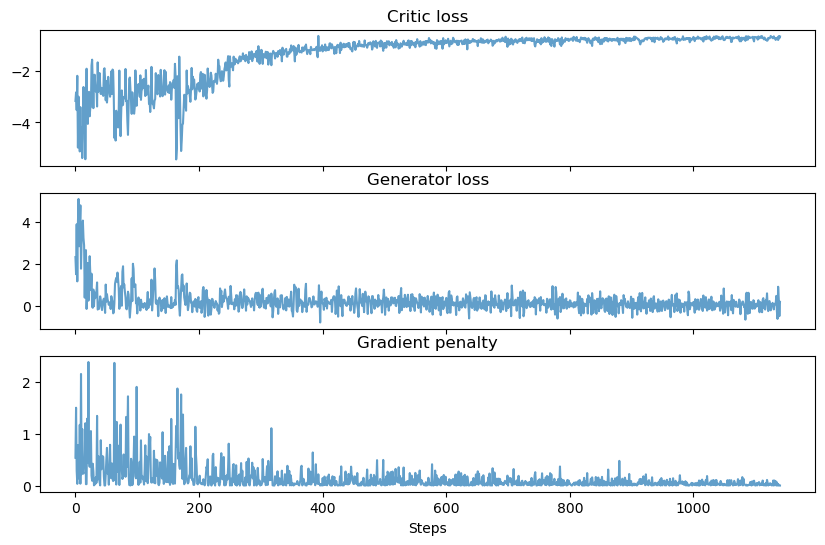

Step 1170: g_loss 0.0298 critic_loss -0.6702 critic fake -0.0909  critic_real -0.5793 penalty 0.0008


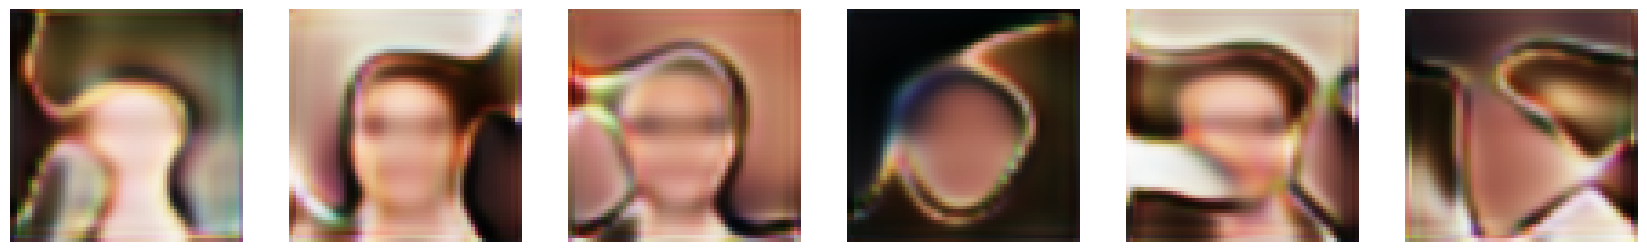

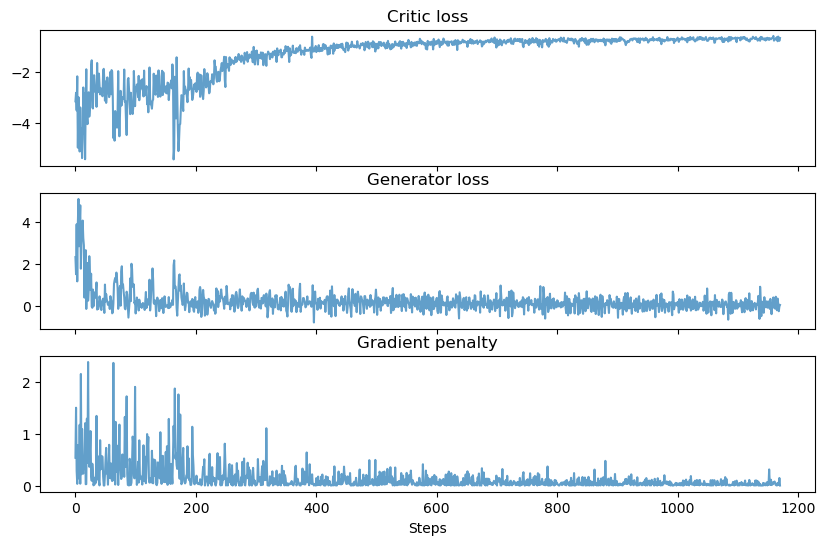

Step 1200: g_loss -0.0212 critic_loss -0.8887 critic fake -0.2468  critic_real -0.6419 penalty 0.4418


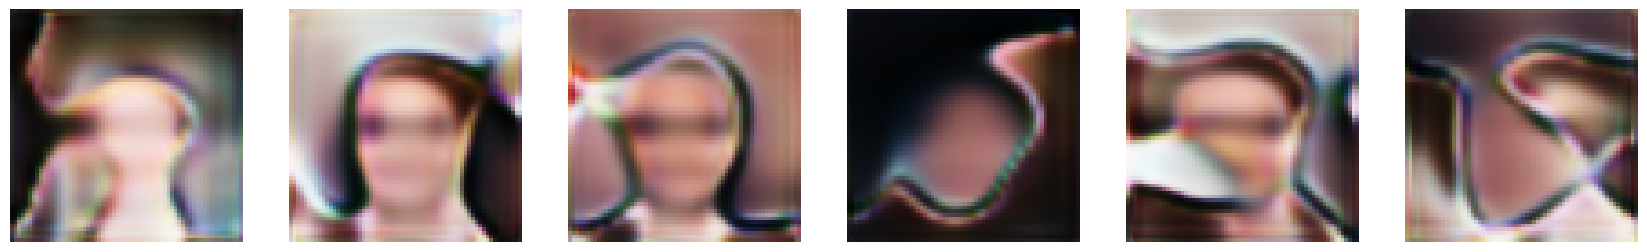

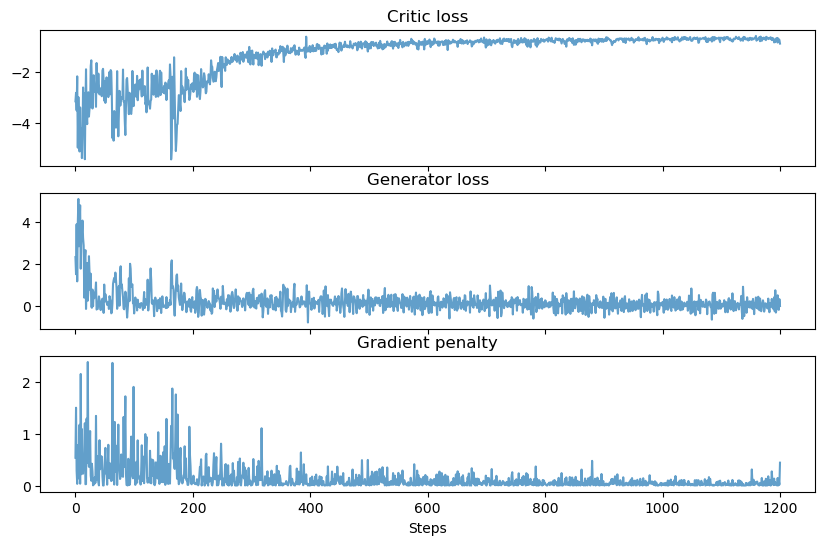

Step 1230: g_loss -0.1552 critic_loss -0.6911 critic fake 0.0448  critic_real -0.7359 penalty 0.0024


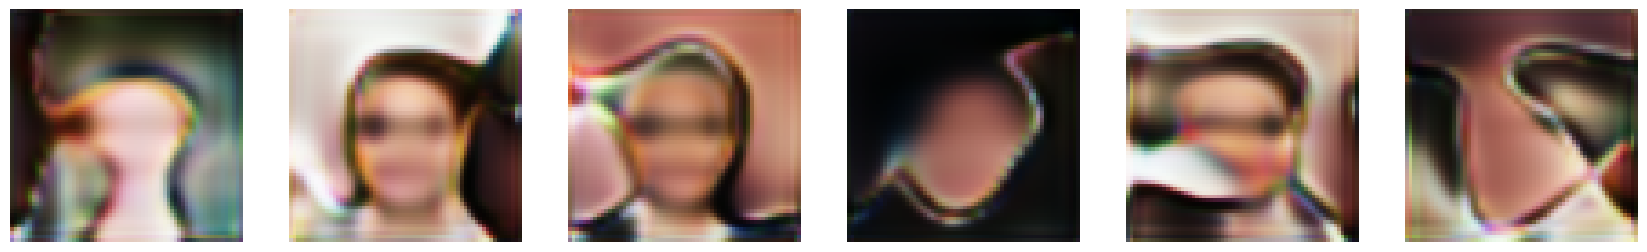

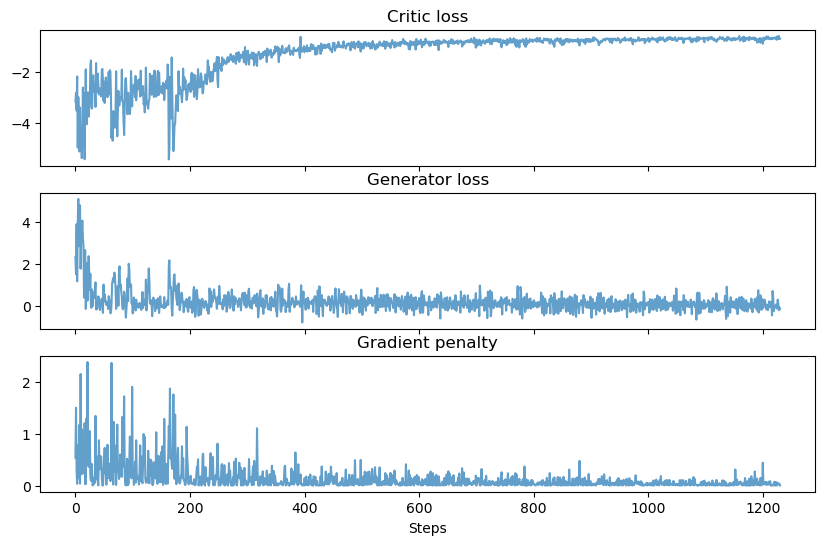

Step 1260: g_loss -0.1112 critic_loss -0.7352 critic fake 0.2481  critic_real -0.9833 penalty 0.0925


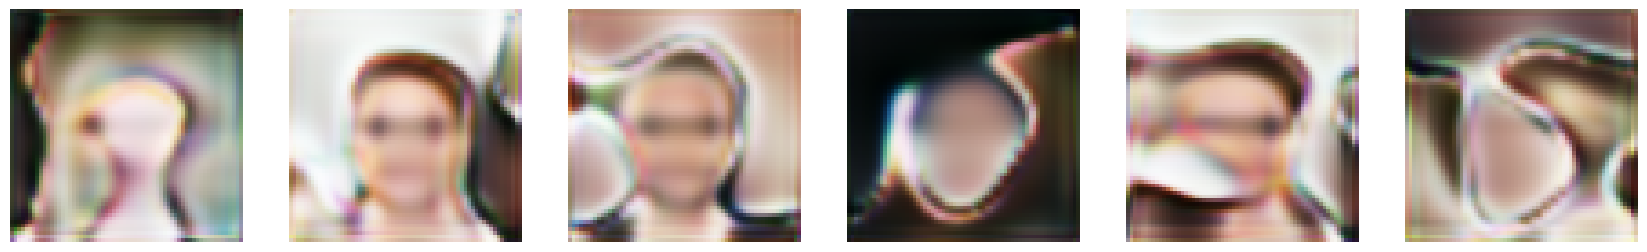

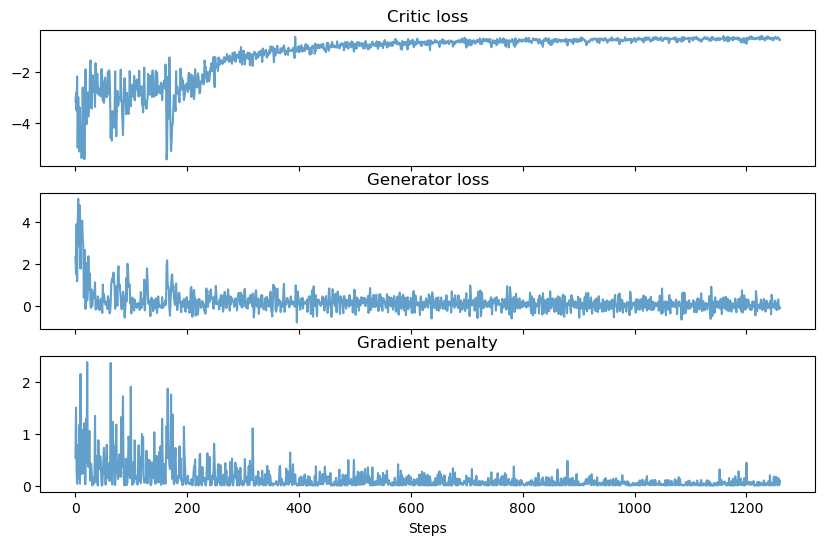

Step 1290: g_loss 0.0675 critic_loss -0.6442 critic fake -0.0747  critic_real -0.5695 penalty 0.0066


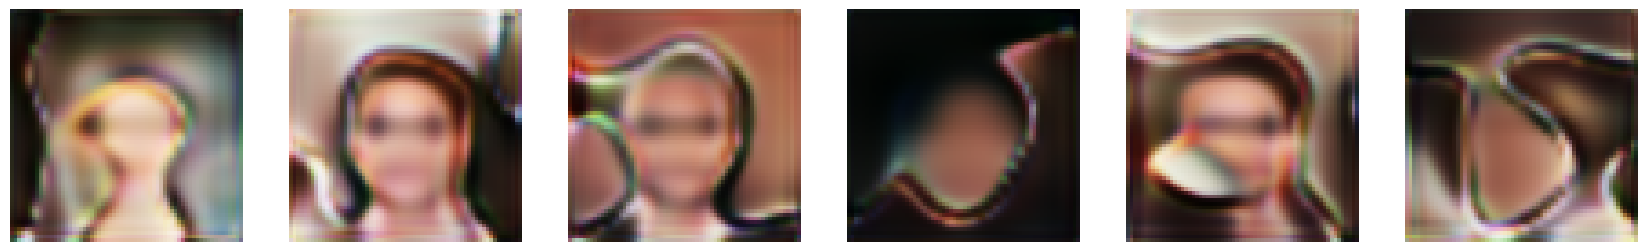

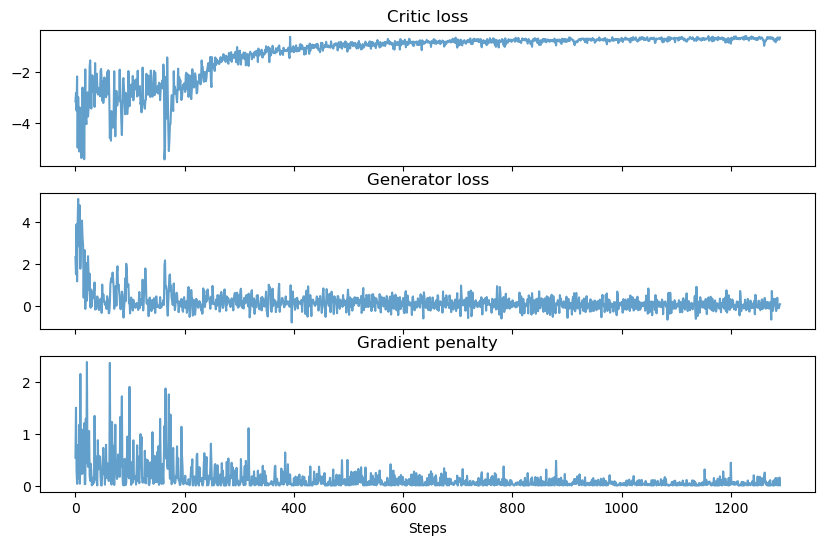

Step 1320: g_loss 0.4362 critic_loss -0.6692 critic fake -0.3659  critic_real -0.3033 penalty 0.0075


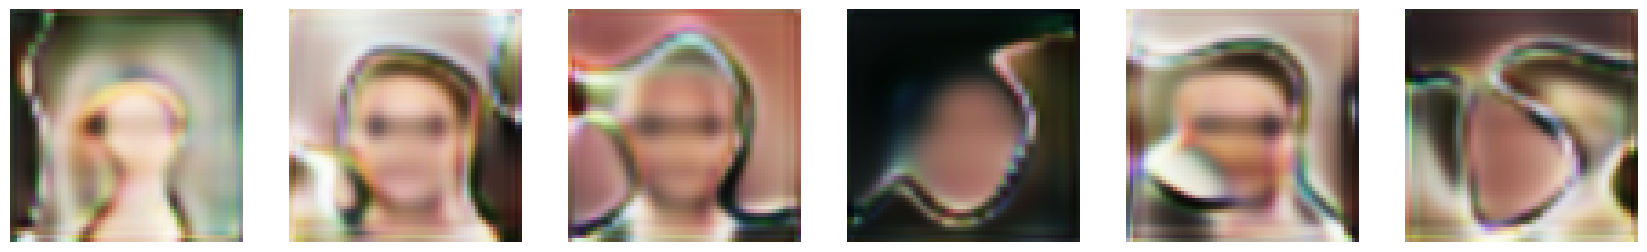

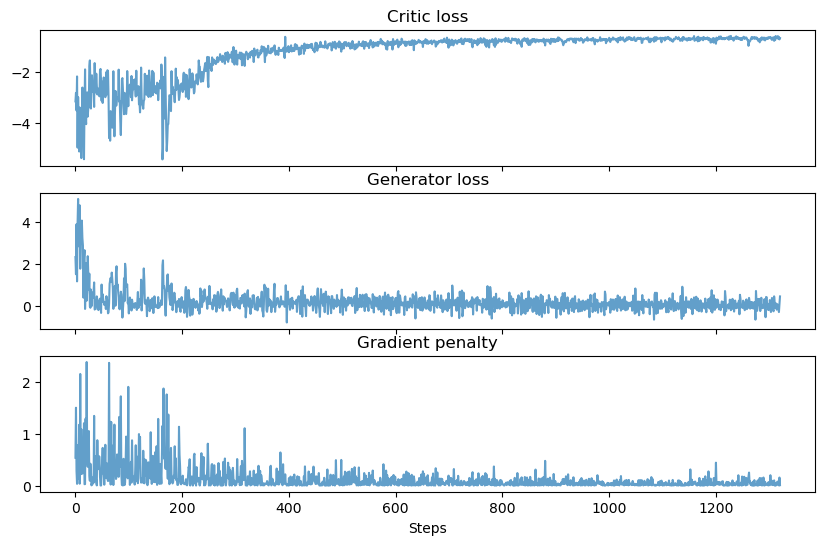

In [ ]:
wgan.train(iter(ds_train), batch_size, 50000, 30)

In [ ]:
wgan.model.summary()

In [ ]:
wgan.critic.summary()

In [ ]:
wgan.generator.summary()

In [ ]:
z = tf.random.normal((8, 128))
generated_images = wgan.generator.predict(z)
wgan.plot_images(generated_images)

In [ ]:
for i in range(20):
    z = tf.random.normal((20, 128))
    images = wgan.generator.predict(z)
    
    grid_row = 1
    grid_col = 20
    f, axarr = plt.subplots(grid_row, grid_col, figsize=(grid_col*4, grid_row*4))
    for row in range(grid_row):
        for col in range(grid_col):
            axarr[col].imshow(images[col]*0.5+0.5)
            axarr[col].axis('off')
    plt.show()

In [ ]:
wgan.generator.save_weights('wgan_gp_celeb_a.weights')